# Generate tables for analysis

In [1]:
%load_ext autoreload
%autoreload 2

from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import utils

pd.set_option('display.max_columns', 150)
pd.options.display.float_format = '{:,.5f}'.format
sns.set_theme(style="darkgrid")

# --- Constants ---
LARGE_CORP_MIN_SALES = 50
MED_CORP_MIN_SALES = 10
# -----------------

def format_thousands(value, tick_number):
    if value >= 1000:
        value = int(round(value / 1000, 0))
        return f"{value}K"
    else:
        return int(value)
    
def format_hundreds(value, tick_number):
    if value >= 1000:
        value = float(round(value / 1000, 1))
        return f"{value}K"
    else:
        return int(value)

def format_percent(value, tick_number):
    return f"{int(value)}%"

def format_millions(value, tick_number):
    return f"${int(value/1000000)}M"

# classify grantee/grantor by corp size
def classify_corp(x):
    if x > LARGE_CORP_MIN_SALES:
        return 3
    elif x > MED_CORP_MIN_SALES:
        return 2
    else:
        return 1
    
DATA_PATH = 'output/'

digest = pd.read_parquet(DATA_PATH + 'digest_full_final.parquet')
sales = pd.read_parquet(DATA_PATH + 'sales_full_final.parquet')

parcel_geo = pd.read_csv(DATA_PATH + 'parcels_geo.csv')
nsa_geo = gpd.read_file('data/atl_nsa.geojson')
nsa_stats = pd.read_csv('data/atl_nsa_stats.csv')

print(f"Len digest: {len(digest)}")
print(f"Len sales: {len(sales)}")

Len digest: 2739296
Len sales: 150284


## Merge geodata with parcels and sales

In [2]:
# Convert "Saledt" to "Sale Year"
sales["Sale Year"] = sales["Saledt"].apply(lambda x: x.split("-")[-1]).astype(int)

# Geocode
digest = digest.merge(parcel_geo, on='PARID', how='left')
sales = sales.merge(parcel_geo, on='PARID', how='left')

# Create valid and invalid subsets for valid and invalid sales
valid_sales = sales[sales["Saleval"] == "0"]
valid_atl = valid_sales[valid_sales["neighborhood"].notna()]

invalid_sales = sales[sales["Saleval"] != "0"]
invalid_atl = invalid_sales[invalid_sales["neighborhood"].notna()]

# Create ATL subsets for total sales and digest
digest_atl = digest[digest["neighborhood"].notna()]
sales_atl = sales[sales["neighborhood"].notna()]

print(f"Parcel records in ATL: {len(digest_atl)}")
print(f"Sale records in ATL: {len(sales_atl)}")
print(f"Len invalid_sales: {len(invalid_sales)}")
print(f"Len invalid_atl: {len(invalid_atl)}")
print(f"Len valid_sales: {len(valid_sales)}")
print(f"Len valid_atl: {len(valid_atl)}")

Parcel records in ATL: 985666
Sale records in ATL: 55454
Len invalid_sales: 37595
Len invalid_atl: 17465
Len valid_sales: 112689
Len valid_atl: 37989


## Figure 1. Total SFH Sales in Fulton County and Atlanta

In [3]:
def calculate_counts(df, label, group_col='Sale Year'):
    return df.groupby(group_col)['PARID'].count().reset_index(name=label)

dfs = []
df_label = {
    'Total': sales,
    'Total Fulton Excl Atl': sales[sales["neighborhood"].isna()],
    'Valid Fulton Excl Atl': valid_sales[valid_sales["neighborhood"].isna()],
    'Invalid Fulton Excl Atl': invalid_sales[invalid_sales["neighborhood"].isna()],
    'Total Atlanta': sales_atl,
    'Valid Atlanta': valid_atl,
    'Invalid Atlanta': invalid_atl
}
for label, df in df_label.items():
    dfs.append(calculate_counts(df, label))

total_sales = reduce(lambda left, right: pd.merge(left, right, on='Sale Year'), dfs)

pct_cols = [
    "Valid Fulton Excl Atl",
    "Invalid Fulton Excl Atl",
    "Valid Atlanta",
    "Invalid Atlanta"
]

pcts = total_sales[pct_cols].divide(total_sales["Total"], axis=0).add_suffix(' %')

total_sales = pd.concat([total_sales, pcts], axis=1)
total_sales

,Sale Year,Total,Total Fulton Excl Atl,Valid Fulton Excl Atl,Invalid Fulton Excl Atl,Total Atlanta,Valid Atlanta,Invalid Atlanta,Valid Fulton Excl Atl %,Invalid Fulton Excl Atl %,Valid Atlanta %,Invalid Atlanta %
0,2010,7126,4380,3408,972,2746,1932,814,0.47825,0.13640,0.27112,0.11423
1,2011,6801,4140,2713,1427,2661,1945,716,0.39891,0.20982,0.28599,0.10528
2,2012,9604,6169,4837,1332,3435,2580,855,0.50364,0.13869,0.26864,0.08903
3,2013,10503,6626,6531,95,3877,3788,89,0.62182,0.00905,0.36066,0.00847
4,2014,10399,6591,6449,142,3808,3608,200,0.62016,0.01366,0.34696,0.01923
5,2015,12998,8347,2393,5954,4651,1183,3468,0.18411,0.45807,0.09101,0.26681
6,2016,12485,8055,7660,395,4430,3825,605,0.61354,0.03164,0.30637,0.04846
7,2017,15748,9790,7532,2258,5958,3053,2905,0.47828,0.14338,0.19387,0.18447
8,2018,16250,10136,7866,2270,6114,3343,2771,0.48406,0.13969,0.20572,0.17052
9,2019,15758,10144,8361,1783,5614,3894,1720,0.53059,0.11315,0.24711,0.10915


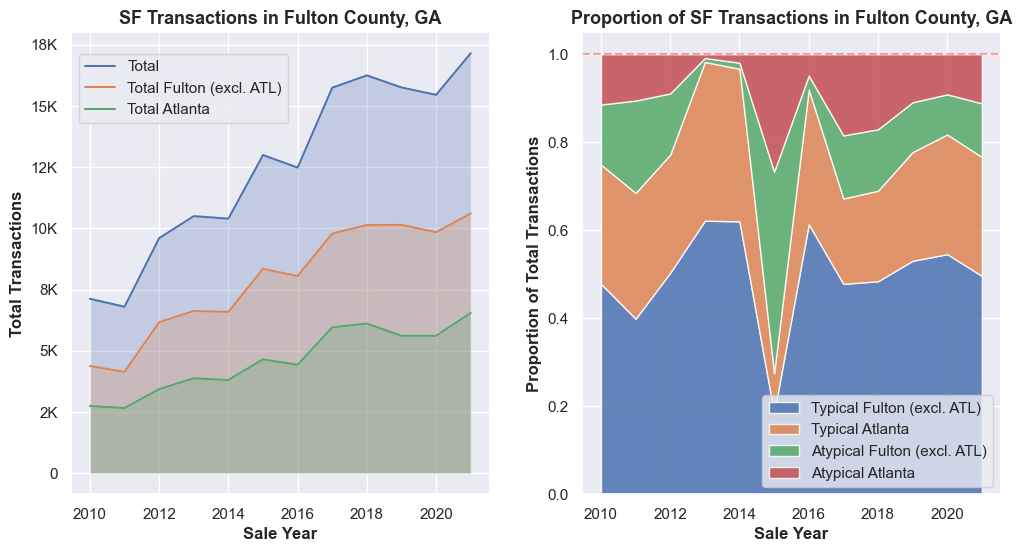

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': .22})

utils.area_plot(
    total_sales,
    "Sale Year",
    ["Total", "Total Fulton Excl Atl", "Total Atlanta"],
    ["Total", "Total Fulton (excl. ATL)", "Total Atlanta"],
    "Sale Year",
    "Total Transactions",
    title="SF Transactions in Fulton County, GA",
    ax=ax[0],
    format_func=format_thousands,
    format_tuple=(0, 1),
    legend={"loc": "upper left", "bbox_to_anchor": (0, 0.97)}
)

utils.stacked_plot(
    total_sales,
    "Sale Year",
    ["Valid Fulton Excl Atl %", "Valid Atlanta %", "Invalid Fulton Excl Atl %", "Invalid Atlanta %"],
    ["Typical Fulton (excl. ATL)", "Typical Atlanta", "Atypical Fulton (excl. ATL)", "Atypical Atlanta"],
    "Sale Year",
    y_label="Proportion of Total Transactions",
    title="Proportion of SF Transactions in Fulton County, GA",
    ax=ax[1],
    legend={"loc": "lower right"},
    opacity=.85
)

ax[1].axhline(y=1, color='red', linestyle='--', alpha=.35)

## Figure 2. Total Sales by Corporates and Table of Invalid Sales

In [5]:
# want total trans in Atlanta; total and invalid broken down by corp purchases and sales
dfs = []
df_label = {
    'Total Corp Trans Atl': sales_atl[(sales_atl['GRANTEE_corp_flag'] == 1) | (sales_atl['GRANTOR_corp_flag'] == 1)],
    'Total Corp Purchases Atl': sales_atl[sales_atl['GRANTEE_corp_flag'] == 1],
    'Total Corp Sales Atl': sales_atl[sales_atl['GRANTOR_corp_flag'] == 1],
    'Invalid Corp Purchases Atl': invalid_atl[invalid_atl['GRANTEE_corp_flag'] == 1],
    'Invalid Corp Sales Atl': invalid_atl[invalid_atl['GRANTOR_corp_flag'] == 1],
    'Valid Corp Purchases Atl': valid_atl[valid_atl['GRANTEE_corp_flag'] == 1],
    'Valid Corp Sales Atl': valid_atl[valid_atl['GRANTOR_corp_flag'] == 1]
}

for label, df in df_label.items():
    dfs.append(calculate_counts(df, label))

atlanta_breakdown = reduce(lambda left, right: pd.merge(left, right, on='Sale Year'), dfs)
total_sales = pd.merge(total_sales, atlanta_breakdown, on='Sale Year')
total_sales["Corp Trans Sum Atl"] = total_sales["Total Corp Purchases Atl"] + total_sales["Total Corp Sales Atl"]

pct_cols = [label for label in df_label.keys() if label != "Total Corp Trans Atl"]
pcts = total_sales[pct_cols].divide(total_sales["Corp Trans Sum Atl"], axis=0).add_suffix(' %')

pcts_of_corp_trans = total_sales[pct_cols].divide(total_sales["Corp Trans Sum Atl"], axis=0).add_suffix(' % Corp Trans')

total_sales = pd.concat([total_sales, pcts, pcts_of_corp_trans], axis=1)
total_sales

,Sale Year,Total,Total Fulton Excl Atl,Valid Fulton Excl Atl,Invalid Fulton Excl Atl,Total Atlanta,Valid Atlanta,Invalid Atlanta,Valid Fulton Excl Atl %,Invalid Fulton Excl Atl %,Valid Atlanta %,Invalid Atlanta %,Total Corp Trans Atl,Total Corp Purchases Atl,Total Corp Sales Atl,Invalid Corp Purchases Atl,Invalid Corp Sales Atl,Valid Corp Purchases Atl,Valid Corp Sales Atl,Corp Trans Sum Atl,Total Corp Purchases Atl %,Total Corp Sales Atl %,Invalid Corp Purchases Atl %,Invalid Corp Sales Atl %,Valid Corp Purchases Atl %,Valid Corp Sales Atl %,Total Corp Purchases Atl % Corp Trans,Total Corp Sales Atl % Corp Trans,Invalid Corp Purchases Atl % Corp Trans,Invalid Corp Sales Atl % Corp Trans,Valid Corp Purchases Atl % Corp Trans,Valid Corp Sales Atl % Corp Trans
0,2010,7126,4380,3408,972,2746,1932,814,0.47825,0.13640,0.27112,0.11423,1254,660,941,372,403,288,538,1601,0.41224,0.58776,0.23235,0.25172,0.17989,0.33604,0.41224,0.58776,0.23235,0.25172,0.17989,0.33604
1,2011,6801,4140,2713,1427,2661,1945,716,0.39891,0.20982,0.28599,0.10528,1185,629,856,342,340,287,516,1485,0.42357,0.57643,0.23030,0.22896,0.19327,0.34747,0.42357,0.57643,0.23030,0.22896,0.19327,0.34747
2,2012,9604,6169,4837,1332,3435,2580,855,0.50364,0.13869,0.26864,0.08903,1594,978,1040,500,325,478,715,2018,0.48464,0.51536,0.24777,0.16105,0.23687,0.35431,0.48464,0.51536,0.24777,0.16105,0.23687,0.35431
3,2013,10503,6626,6531,95,3877,3788,89,0.62182,0.00905,0.36066,0.00847,1729,1123,1231,67,30,1056,1201,2354,0.47706,0.52294,0.02846,0.01274,0.44860,0.51020,0.47706,0.52294,0.02846,0.01274,0.44860,0.51020
4,2014,10399,6591,6449,142,3808,3608,200,0.62016,0.01366,0.34696,0.01923,1632,957,1096,166,61,791,1035,2053,0.46615,0.53385,0.08086,0.02971,0.38529,0.50414,0.46615,0.53385,0.08086,0.02971,0.38529,0.50414
5,2015,12998,8347,2393,5954,4651,1183,3468,0.18411,0.45807,0.09101,0.26681,2105,1193,1385,1084,1122,109,263,2578,0.46276,0.53724,0.42048,0.43522,0.04228,0.10202,0.46276,0.53724,0.42048,0.43522,0.04228,0.10202
6,2016,12485,8055,7660,395,4430,3825,605,0.61354,0.03164,0.30637,0.04846,1999,1031,1515,334,274,697,1241,2546,0.40495,0.59505,0.13119,0.10762,0.27376,0.48743,0.40495,0.59505,0.13119,0.10762,0.27376,0.48743
7,2017,15748,9790,7532,2258,5958,3053,2905,0.47828,0.14338,0.19387,0.18447,3338,1962,2328,1769,1423,193,905,4290,0.45734,0.54266,0.41235,0.33170,0.04499,0.21096,0.45734,0.54266,0.41235,0.33170,0.04499,0.21096
8,2018,16250,10136,7866,2270,6114,3343,2771,0.48406,0.13969,0.20572,0.17052,3609,2138,2536,1909,1367,229,1169,4674,0.45742,0.54258,0.40843,0.29247,0.04899,0.25011,0.45742,0.54258,0.40843,0.29247,0.04899,0.25011
9,2019,15758,10144,8361,1783,5614,3894,1720,0.53059,0.11315,0.24711,0.10915,2965,1377,2187,1109,732,268,1455,3564,0.38636,0.61364,0.31117,0.20539,0.07520,0.40825,0.38636,0.61364,0.31117,0.20539,0.07520,0.40825


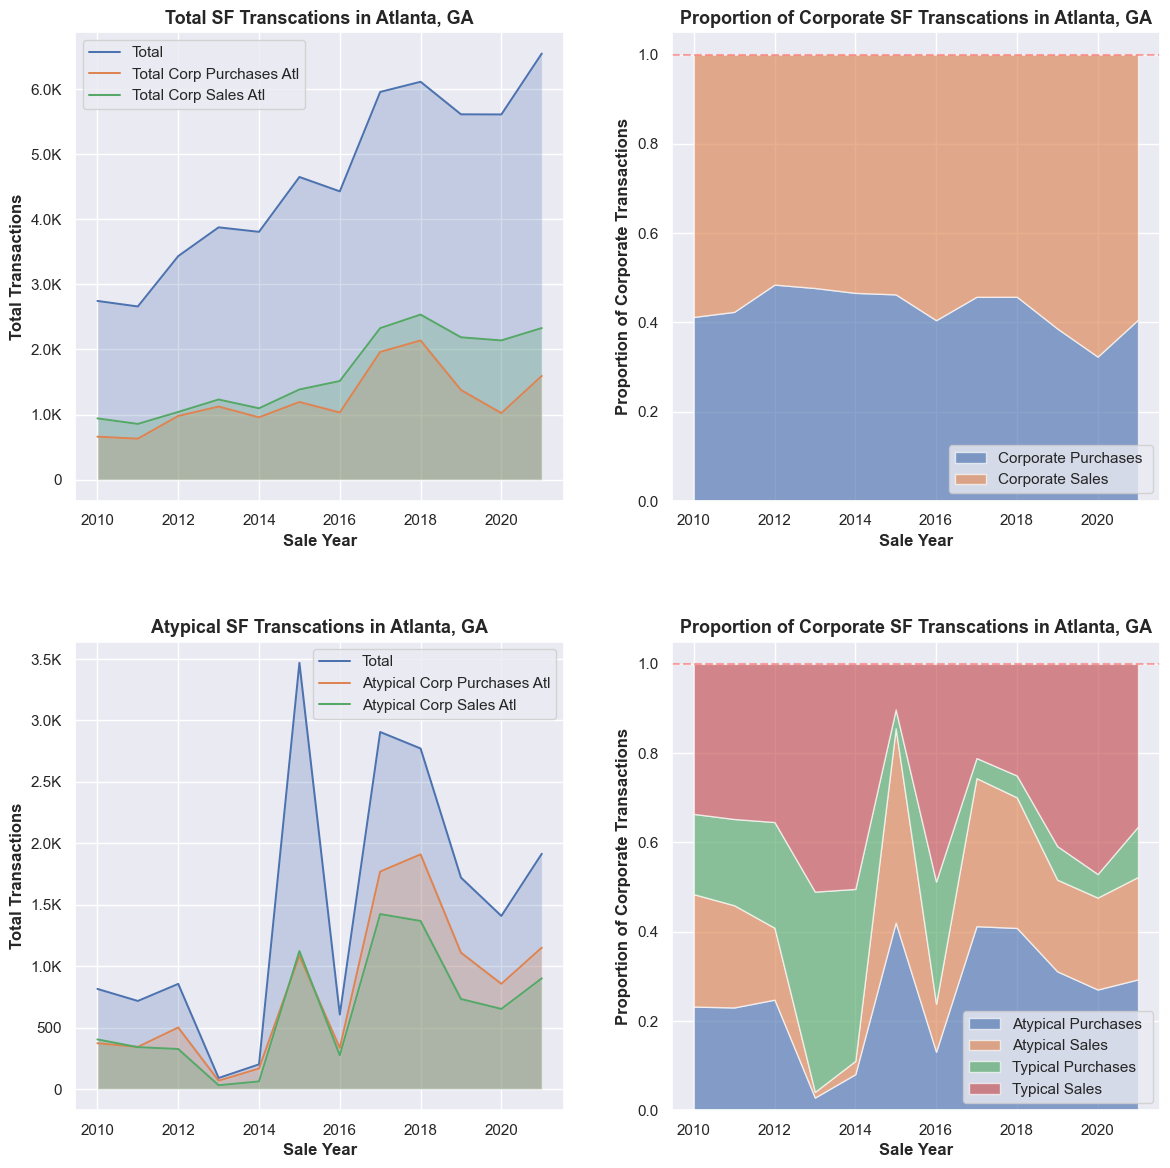

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14), gridspec_kw={'wspace': .22, 'hspace': .3})

for i, subset in enumerate(["Total", "Invalid"]):
    name = "Total"
    if i == 1:
        loc="upper right"
    else:
        loc="upper left"
    if subset == "Invalid":
        name = "Atypical"
    col_labels = ["Total", f"{subset} Corp Purchases Atl", f"{subset} Corp Sales Atl"]
    utils.area_plot(
        total_sales,
        "Sale Year",
        [f"{subset} Atlanta", f"{subset} Corp Purchases Atl", f"{subset} Corp Sales Atl"],
        [x.replace("Invalid", "Atypical") for x in col_labels],
        title=f"{name} SF Transcations in Atlanta, GA",
        x_label="Sale Year",
        y_label="Total Transactions",
        ax=ax[i][0],
        legend={"loc": loc},
        format_func=format_hundreds,
        format_tuple=(0, 1),
    )
    
    stacked_cols = [f"{subset} Corp Purchases Atl %", f"{subset} Corp Sales Atl %"]
    trans_level = " Corporate"
    if subset == "Invalid":
        stacked_cols = [
            "Invalid Corp Purchases Atl % Corp Trans",
            "Invalid Corp Sales Atl % Corp Trans",
            "Valid Corp Purchases Atl % Corp Trans",
            "Valid Corp Sales Atl % Corp Trans"
        ]
        trans_level = " Corporate"
    col_labels = [x.replace("Atl % Corp Trans", "").replace("Atl %", "").replace("Total Corp", "Corporate").replace("Valid", "Typical").replace("Invalid", "Atypical") for x in stacked_cols]
    if subset == "Invalid":
        col_labels = [x.replace(" Corp", "").replace("Valid", "Typical").replace("Invalid", "Atypical") for x in col_labels]


    utils.stacked_plot(
        total_sales,
        "Sale Year",
        stacked_cols,
        col_labels,
        title=f"Proportion of{trans_level} SF Transcations in Atlanta, GA",
        y_label=f"Proportion of{trans_level} Transactions",
        x_label="Sale Year",
        ax=ax[i][1],
        opacity=.65,
        legend={"loc": "lower right"}
    )
    
    ax[i][1].axhline(y=1, color='red', linestyle='--', alpha=.35)

## Figure 3. Sales by Transaction Scale
Note: switch with Figure 2 (e.g. this figure should come before previous) for paper

In [7]:
# Note includes valid sales and purchases from govt, bank
sale_scale = pd.read_csv("output/sale_scale.csv")
sale_scale["TAXYR"] = (sale_scale["TAXYR"].astype(int) - 1)
sale_scale = sale_scale.rename(columns={"TAXYR": "Sale Year"})

In [8]:
# Want to join sale_scale to sale so we have scale of both GRANTEE and GRANTOR
sales = sales.merge(
    sale_scale[["Sale Year", "entity_addr", "total_trans_fulton"]],
    left_on=["Sale Year", "GRANTEE_match_addr"], # GRANTEE scale
    right_on=["Sale Year", "entity_addr"],
    how="left"
).rename(columns={"total_trans_fulton": "Buyer Transactions Fulton"}).drop(
    columns=["entity_addr"]
).merge(
    sale_scale[["Sale Year", "entity_addr", "total_trans_fulton"]],
    left_on=["Sale Year", "GRANTOR_match_addr"], # GRANTOR scale
    right_on=["Sale Year", "entity_addr"],
    how="left"
).rename(columns={"total_trans_fulton": "Seller Transactions Fulton"}).drop(
    columns=["entity_addr"]
)

for col in ["Buyer Transactions Fulton", "Seller Transactions Fulton"]:
    sales[col] = sales[col].fillna(0).astype(int)

In [9]:
sales.head(5)[["Sale Year", "GRANTEE_match_addr", "GRANTOR_match_addr", "Buyer Transactions Fulton", "Seller Transactions Fulton"]]

,Sale Year,GRANTEE_match_addr,GRANTOR_match_addr,Buyer Transactions Fulton,Seller Transactions Fulton
0,2017,11340 LAKEFIELD 30097,<NA>,161,0
1,2017,<NA>,<NA>,0,0
2,2021,31 HUDSON YARDS 10001,4651 ROSWELL 30342,185,82
3,2018,1000 ABERNATHY 30328,1580 TERRELL MILL 30067,95,37
4,2018,3694 BRADFORD 30331,1000 ABERNATHY 30328,1,95


In [10]:
sales["Buyer Scale"] = sales[
    sales["GRANTEE_corp_flag"] == 1
]["Buyer Transactions Fulton"].apply(classify_corp)

sales["Seller Scale"] = sales[
    sales["GRANTOR_corp_flag"] == 1
]["Seller Transactions Fulton"].apply(classify_corp)

for col in ["Buyer Scale", "Seller Scale"]:
    sales[col] = sales[col].fillna(0).astype(int)

sales_atl = sales[sales["neighborhood"].notna()]
# Add scale metrics to total sales table; e.g. count of sales by scale
# so we want to sum total sales, total valid sales where scale is 1, 2, 3 for each year
dfs = [total_sales] + []

scales = {
    0: "Individual",
    1: "Small Corporate",
    2: "Medium Corporate",
    3: "Large Corporate",
}

names = {
    "Seller": "Sales",
    "Buyer": "Purchases"
}

for trans_type in ["Buyer", "Seller"]:
    for i in scales.keys():
        df = calculate_counts(sales_atl[sales_atl[f"{trans_type} Scale"] == i], f"{scales[i]} {names[trans_type]} Atlanta")
        dfs.append(df)
        
total_sales = reduce(lambda left, right: pd.merge(left, right, on='Sale Year'), dfs)
total_sales

,Sale Year,Total,Total Fulton Excl Atl,Valid Fulton Excl Atl,Invalid Fulton Excl Atl,Total Atlanta,Valid Atlanta,Invalid Atlanta,Valid Fulton Excl Atl %,Invalid Fulton Excl Atl %,Valid Atlanta %,Invalid Atlanta %,Total Corp Trans Atl,Total Corp Purchases Atl,Total Corp Sales Atl,Invalid Corp Purchases Atl,Invalid Corp Sales Atl,Valid Corp Purchases Atl,Valid Corp Sales Atl,Corp Trans Sum Atl,Total Corp Purchases Atl %,Total Corp Sales Atl %,Invalid Corp Purchases Atl %,Invalid Corp Sales Atl %,Valid Corp Purchases Atl %,Valid Corp Sales Atl %,Total Corp Purchases Atl % Corp Trans,Total Corp Sales Atl % Corp Trans,Invalid Corp Purchases Atl % Corp Trans,Invalid Corp Sales Atl % Corp Trans,Valid Corp Purchases Atl % Corp Trans,Valid Corp Sales Atl % Corp Trans,Individual Purchases Atlanta,Small Corporate Purchases Atlanta,Medium Corporate Purchases Atlanta,Large Corporate Purchases Atlanta,Individual Sales Atlanta,Small Corporate Sales Atlanta,Medium Corporate Sales Atlanta,Large Corporate Sales Atlanta
0,2010,7126,4380,3408,972,2746,1932,814,0.47825,0.13640,0.27112,0.11423,1254,660,941,372,403,288,538,1601,0.41224,0.58776,0.23235,0.25172,0.17989,0.33604,0.41224,0.58776,0.23235,0.25172,0.17989,0.33604,2086,515,138,7,1805,630,303,8
1,2011,6801,4140,2713,1427,2661,1945,716,0.39891,0.20982,0.28599,0.10528,1185,629,856,342,340,287,516,1485,0.42357,0.57643,0.23030,0.22896,0.19327,0.34747,0.42357,0.57643,0.23030,0.22896,0.19327,0.34747,2032,474,106,49,1805,588,158,110
2,2012,9604,6169,4837,1332,3435,2580,855,0.50364,0.13869,0.26864,0.08903,1594,978,1040,500,325,478,715,2018,0.48464,0.51536,0.24777,0.16105,0.23687,0.35431,0.48464,0.51536,0.24777,0.16105,0.23687,0.35431,2457,699,160,119,2395,749,206,85
3,2013,10503,6626,6531,95,3877,3788,89,0.62182,0.00905,0.36066,0.00847,1729,1123,1231,67,30,1056,1201,2354,0.47706,0.52294,0.02846,0.01274,0.44860,0.51020,0.47706,0.52294,0.02846,0.01274,0.44860,0.51020,2754,765,152,206,2646,950,225,56
4,2014,10399,6591,6449,142,3808,3608,200,0.62016,0.01366,0.34696,0.01923,1632,957,1096,166,61,791,1035,2053,0.46615,0.53385,0.08086,0.02971,0.38529,0.50414,0.46615,0.53385,0.08086,0.02971,0.38529,0.50414,2851,758,94,105,2712,942,153,1
5,2015,12998,8347,2393,5954,4651,1183,3468,0.18411,0.45807,0.09101,0.26681,2105,1193,1385,1084,1122,109,263,2578,0.46276,0.53724,0.42048,0.43522,0.04228,0.10202,0.46276,0.53724,0.42048,0.43522,0.04228,0.10202,3458,942,211,40,3266,1166,195,24
6,2016,12485,8055,7660,395,4430,3825,605,0.61354,0.03164,0.30637,0.04846,1999,1031,1515,334,274,697,1241,2546,0.40495,0.59505,0.13119,0.10762,0.27376,0.48743,0.40495,0.59505,0.13119,0.10762,0.27376,0.48743,3399,881,144,6,2915,1316,191,8
7,2017,15748,9790,7532,2258,5958,3053,2905,0.47828,0.14338,0.19387,0.18447,3338,1962,2328,1769,1423,193,905,4290,0.45734,0.54266,0.41235,0.33170,0.04499,0.21096,0.45734,0.54266,0.41235,0.33170,0.04499,0.21096,3996,1481,315,166,3630,1707,486,135
8,2018,16250,10136,7866,2270,6114,3343,2771,0.48406,0.13969,0.20572,0.17052,3609,2138,2536,1909,1367,229,1169,4674,0.45742,0.54258,0.40843,0.29247,0.04899,0.25011,0.45742,0.54258,0.40843,0.29247,0.04899,0.25011,3976,1472,285,381,3578,1779,466,291
9,2019,15758,10144,8361,1783,5614,3894,1720,0.53059,0.11315,0.24711,0.10915,2965,1377,2187,1109,732,268,1455,3564,0.38636,0.61364,0.31117,0.20539,0.07520,0.40825,0.38636,0.61364,0.31117,0.20539,0.07520,0.40825,4237,987,227,163,3427,1655,338,194


In [11]:
pct_cols = [
    "Individual Purchases Atlanta",
    "Small Corporate Purchases Atlanta",
    "Medium Corporate Purchases Atlanta",
    "Large Corporate Purchases Atlanta",
    "Individual Sales Atlanta",
    "Small Corporate Sales Atlanta",
    "Medium Corporate Sales Atlanta",
    "Large Corporate Sales Atlanta"
]

pct_by_type = total_sales[pct_cols].divide(total_sales["Total Atlanta"], axis=0).add_suffix(' %')

total_sales = pd.concat([total_sales, pct_by_type], axis=1)

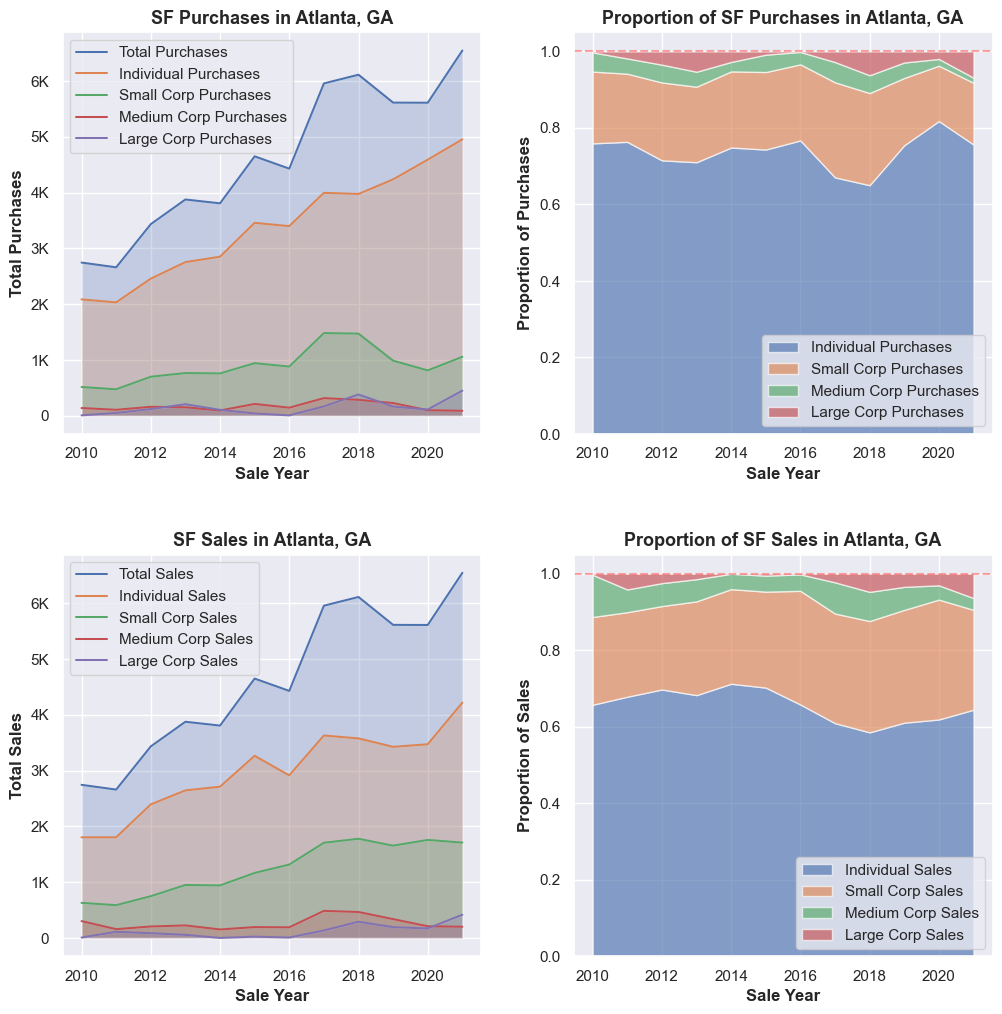

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': .22, 'hspace': .3})

for i, type in enumerate(["Purchases", "Sales"]):
    utils.area_plot(
        df=total_sales,
        x="Sale Year",
        cols=["Total Atlanta"] + [f"{scales[i]} {type} Atlanta" for i in scales.keys()],
        labels=[f"Total {type}"] + [f"{scales[i]} {type}".replace("Corporate", "Corp") for i in scales.keys()],
        x_label="Sale Year",
        y_label=f"Total {type}",
        title=f"SF {type} in Atlanta, GA",
        ax=ax[i][0],
        format_func=format_thousands,
        format_tuple=(0, 1),
        legend={"loc": "upper left"}
    )
    
    utils.stacked_plot(
        df=total_sales,
        x="Sale Year",
        cols=[f"{scales[i]} {type} Atlanta %" for i in scales.keys()],
        labels=[f"{scales[i]} {type}".replace("Corporate", "Corp") for i in scales.keys()],
        x_label="Sale Year",
        y_label=f"Proportion of {type}",
        title=f"Proportion of SF {type} in Atlanta, GA",
        ax=ax[i][1],
        opacity=.65,
        legend={"loc": "lower right"}
    )
    
    ax[i][1].axhline(y=1, color='red', linestyle='--', alpha=.35)

## Figure 4. Ownership of SFH Rentals

In [13]:
owner_scale = pd.read_csv("output/owner_scale.csv")
owner_scale.head(2)

,TAXYR,owner_addr,count_owned_fulton_yr,assoc_owner_names
0,2010,0 54541 30308,1,['MARSH ADRIAN S']
1,2010,0 99 - 22 215TH 11429,1,"['COKLEY JEREL &', 'COKLEY JEREL &']"


In [14]:
digest = digest.merge(
    owner_scale[["TAXYR", "owner_addr", "count_owned_fulton_yr"]],
    on=["TAXYR", "owner_addr"],
    how="left"
)

digest["owner scale"] = digest[digest["own_corp_flag"] == 1]["count_owned_fulton_yr"].apply(classify_corp)
digest["owner scale"] = digest["owner scale"].fillna(0).astype(int)

In [15]:
rentals = digest[digest["rental_flag"] == 1]
rentals_atl = rentals[rentals["neighborhood"].notna()]

num_rentals_fulton = calculate_counts(rentals, "Rentals Fulton", group_col="TAXYR")
num_rentals_atl = calculate_counts(rentals_atl, "Rentals Atlanta", group_col="TAXYR")

dfs = [num_rentals_fulton] + [num_rentals_atl] + []

for scale in scales.keys():
    df = calculate_counts(rentals[rentals["owner scale"] == scale], f"{scales[scale]} Fulton", group_col="TAXYR")
    dfs.append(df)
    
    df = calculate_counts(rentals_atl[rentals_atl["owner scale"] == scale], f"{scales[scale]} Atlanta", group_col="TAXYR")
    dfs.append(df)

rental_summary = reduce(lambda left, right: pd.merge(left, right, on='TAXYR'), dfs)

In [16]:
dfs = [rental_summary] + []

pct_cols_fulton = [
    "Individual Fulton",
    "Small Corporate Fulton",
    "Medium Corporate Fulton",
    "Large Corporate Fulton",
]
pct_cols_atl = [
    "Individual Atlanta",
    "Small Corporate Atlanta",
    "Medium Corporate Atlanta",
    "Large Corporate Atlanta"
]

pct_rental_type_fulton = rental_summary[pct_cols_fulton].divide(rental_summary["Rentals Fulton"], axis=0).add_suffix(' %')
pct_rental_type_atl = rental_summary[pct_cols_atl].divide(rental_summary["Rentals Atlanta"], axis=0).add_suffix(' %')

dfs = dfs + [pct_rental_type_fulton, pct_rental_type_atl]

rental_summary = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)
rental_summary

,TAXYR,Rentals Fulton,Rentals Atlanta,Individual Fulton,Individual Atlanta,Small Corporate Fulton,Small Corporate Atlanta,Medium Corporate Fulton,Medium Corporate Atlanta,Large Corporate Fulton,Large Corporate Atlanta,Individual Fulton %,Small Corporate Fulton %,Medium Corporate Fulton %,Large Corporate Fulton %,Individual Atlanta %,Small Corporate Atlanta %,Medium Corporate Atlanta %,Large Corporate Atlanta %
0,2010,38105,21225,28657,15396,5650,3389,2442,1564,1356,876,0.75205,0.14827,0.06409,0.03559,0.72537,0.15967,0.07369,0.04127
1,2011,39472,21823,29315,15477,6025,3652,2609,1769,1523,925,0.74268,0.15264,0.06610,0.03858,0.70921,0.16735,0.08106,0.04239
2,2012,39926,21935,29485,15410,6443,3896,2769,1926,1229,703,0.73849,0.16137,0.06935,0.03078,0.70253,0.17762,0.08780,0.03205
3,2013,41161,22255,29661,15277,6950,4139,2924,1861,1626,978,0.72061,0.16885,0.07104,0.03950,0.68645,0.18598,0.08362,0.04395
4,2014,42318,22544,29297,15036,7291,4218,3221,2087,2509,1203,0.69231,0.17229,0.07611,0.05929,0.66696,0.18710,0.09257,0.05336
5,2015,42906,22550,28653,14681,7688,4405,3447,2013,3118,1451,0.66781,0.17918,0.08034,0.07267,0.65104,0.19534,0.08927,0.06435
6,2016,39492,22693,25709,14473,7407,4754,3610,2258,2766,1208,0.65099,0.18756,0.09141,0.07004,0.63777,0.20949,0.09950,0.05323
7,2017,43090,22577,27684,14146,8493,4973,3820,2165,3093,1293,0.64247,0.19710,0.08865,0.07178,0.62657,0.22027,0.09589,0.05727
8,2018,42581,22212,26421,13326,8875,5339,3408,1946,3877,1601,0.62049,0.20843,0.08004,0.09105,0.59995,0.24037,0.08761,0.07208
9,2019,42667,22122,25386,12618,9307,5735,3812,2298,4162,1471,0.59498,0.21813,0.08934,0.09755,0.57038,0.25924,0.10388,0.06649


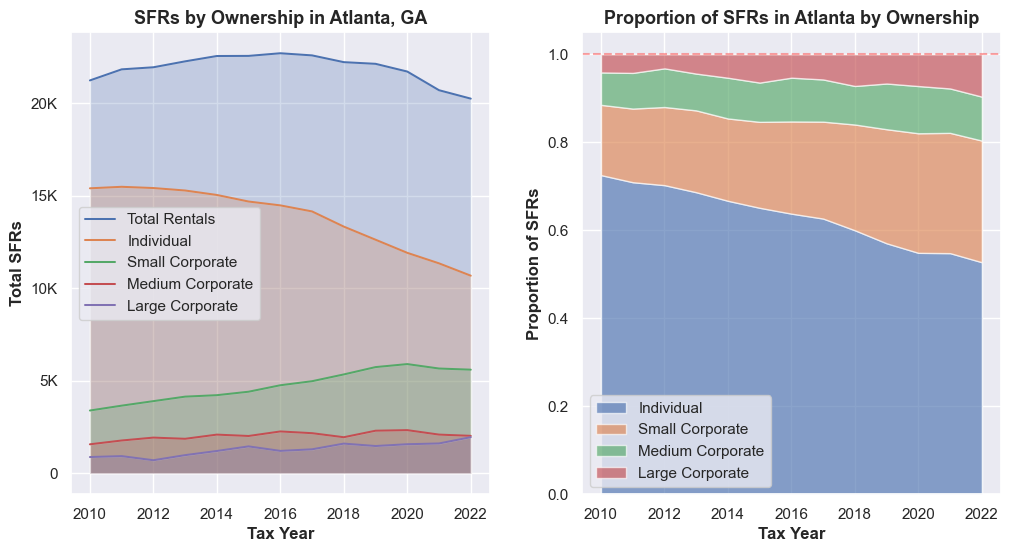

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': .22, 'hspace': .3})

area = "Atlanta"

utils.area_plot(
    rental_summary,
    "TAXYR",
    [f"Rentals {area}", f"Individual {area}", f"Small Corporate {area}", f"Medium Corporate {area}", f"Large Corporate {area}"],
    [f"Total Rentals", f"Individual", f"Small Corporate", f"Medium Corporate", f"Large Corporate"],
    "Tax Year",
    "Total SFRs",
    f"SFRs by Ownership in {area}, GA",
    legend={"loc": "center left"},
    ax=ax[0],
    format_func=format_thousands,
    format_tuple=(0, 1)
)

utils.stacked_plot(
    rental_summary,
    "TAXYR",
    [f"Individual {area} %", f"Small Corporate {area} %", f"Medium Corporate {area} %", f"Large Corporate {area} %"],
    [f"Individual", f"Small Corporate", f"Medium Corporate", f"Large Corporate"],
    "Tax Year",
    y_label="Proportion of SFRs",
    title=f"Proportion of SFRs in {area} by Ownership",
    legend={"loc": "lower left"},
    ax=ax[1],
    opacity=.65
)

ax[1].axhline(y=1, color='red', linestyle='--', alpha=.35)

## Figure 5. Neighborhood characteristics

In [18]:
nsa_geo.rename(columns={"NEIGHBORHO": "neighborhood"}, inplace=True)
nsa_geo = nsa_geo[['STATISTICA', 'neighborhood', 'geometry']]

nsa_stats.rename(columns={"Details": "neighborhood"}, inplace=True)
nsa_stats = nsa_stats[[
    "GEOID",
    "neighborhood",
    "Median household income 2021",
    "% Not Hispanic Black or African American alone 2021",
]]

nsa_geo = nsa_geo.merge(
    nsa_stats,
    on="neighborhood",
    how="left"
)

dropped_nbhds = [
    'East Lake, The Villages at East Lake',
    'Edgewood',
    'Candler Park, Druid Hills',
    'Kirkwood',
    'Lake Claire',
    'East Atlanta',
    'Airport'
]

nsa_geo = nsa_geo[~nsa_geo["neighborhood"].isin(dropped_nbhds)]

c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

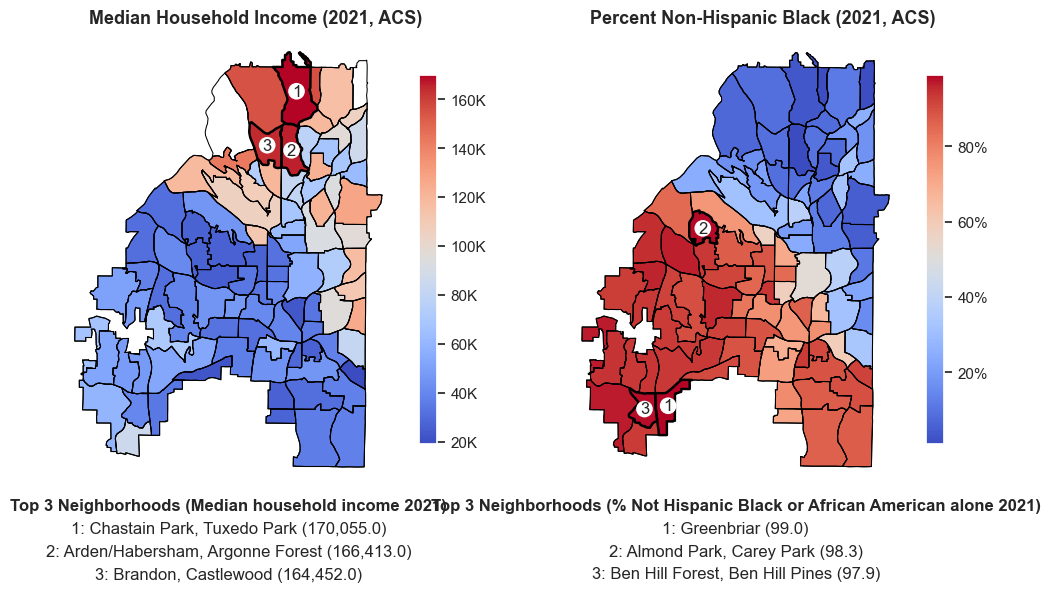

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
hues = [
    "Median household income 2021",
    "% Not Hispanic Black or African American alone 2021",
]
titles = [
    "Median Household Income (2021, ACS)",
    "Percent Non-Hispanic Black (2021, ACS)",
]
highlight = [
    "Castleberry Hill, Downtown",
    "Buckhead Heights, Lenox, Ridgedale Park"
    #"Kingswood, Mt. Paran/Northside, Mt. Paran Parkway, Randall Mill, West Paces Ferry/Northside, Whitewater Creek",
    #"Chastain Park, Tuxedo Park",
    #'Adair Park, Pittsburgh',
    #'Lakewood, Leila Valley, Norwood Manor, Rebel Valley Forest',
]

utils.map(
    nsa_geo,
    color=hues[0],
    title=titles[0],
    nbhd_df=nsa_geo,
    ax=axes[0],
    highlight=highlight,
    format_func=format_thousands
)

utils.map(
    nsa_geo,
    color=hues[1],
    title=titles[1],
    nbhd_df=nsa_geo,
    ax=axes[1],
    highlight=highlight,
    format_func=format_percent
)

## Figure 6. Sales per SFH Parcel, Proportion Valid SFH Sales by Neighborhood

In [20]:
dfs = []

dfs.append(calculate_counts(sales_atl, "Total Sales", group_col="neighborhood"))
dfs.append(calculate_counts(invalid_atl, "Invalid Sales", group_col="neighborhood"))
dfs.append(calculate_counts(digest_atl[digest_atl["TAXYR"] == 2022], "Total Parcels 2022", group_col="neighborhood"))

atl_sales_summary = reduce(lambda left, right: pd.merge(left, right, on='neighborhood'), dfs)

atl_sales_summary["Sales Per Parcel"] = atl_sales_summary["Total Sales"].divide(atl_sales_summary["Total Parcels 2022"], axis=0)
atl_sales_summary["Percent Invalid Sales"] = atl_sales_summary["Invalid Sales"].divide(atl_sales_summary["Total Sales"], axis=0)
atl_sales_summary = atl_sales_summary.merge(nsa_geo[["neighborhood", "geometry"]], on="neighborhood", how="left")

atl_sales_summary.sort_values("Sales Per Parcel", ascending=False).head(3)

,neighborhood,Total Sales,Invalid Sales,Total Parcels 2022,Sales Per Parcel,Percent Invalid Sales,geometry
68,Lindbergh/Morosgo,88,16,55,1.60000,0.18182,"POLYGON ((-84.37344 33.81581, -84.37316 33.815..."
24,"Berkeley Park, Blandtown, Hills Park",1106,163,937,1.18036,0.14738,"POLYGON ((-84.40828 33.78821, -84.40767 33.788..."
47,"Collier Hills, Collier Hills North, Colonial H...",441,46,405,1.08889,0.10431,"POLYGON ((-84.38923 33.81761, -84.38916 33.817..."


c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",


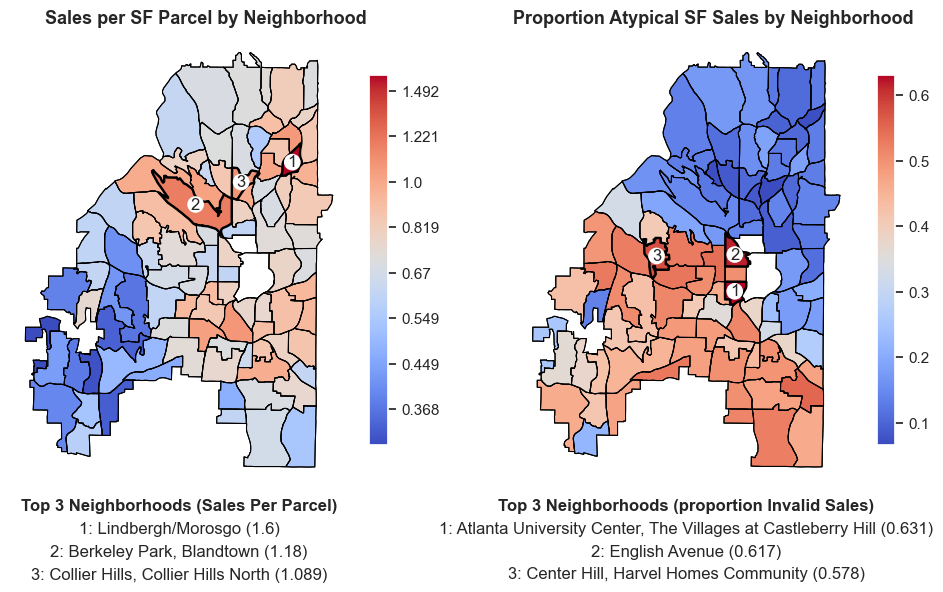

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

atl_sales_summary = atl_sales_summary.fillna(0)
#outliers_1 = ["Georgia Tech, Marietta Street Artery", "Lindbergh/Morosgo"]
highlight1 = [
    'Carver Hills, Rockdale, Scotts Crossing, West Highlands',
    'Lindbergh/Morosgo',
    'Adair Park, Pittsburgh',
]
highlight2 = [
    "English Avenue",
    'Atlanta University Center, The Villages at Castleberry Hill',
    'Center Hill, Harvel Homes Community',
]
utils.map(
    atl_sales_summary,
    color="Sales Per Parcel",
    title="Sales per SF Parcel by Neighborhood",
    nbhd_df=nsa_geo,
    ax=ax[0],
    log=True,
    highlight=highlight1,
)

utils.map(
    atl_sales_summary,
    color="Percent Invalid Sales",
    title="Proportion Atypical SF Sales by Neighborhood",
    nbhd_df=nsa_geo,
    ax=ax[1],
    highlight=highlight2,
)

## Figure 7. Percent of Sales at each Transaction Scale by Neighborhood

In [22]:
digest_atl_2022 = digest[(digest["TAXYR"] == 2022) & (digest["neighborhood"].notna())]

dfs = [calculate_counts(digest_atl_2022, "Total Parcels 2022", group_col="neighborhood")] + []

for scale in scales:
    df = calculate_counts(
        digest_atl_2022[digest_atl_2022["owner scale"] == scale],
        f"{scales[scale]}",
        group_col="neighborhood"
    )
    
    dfs.append(df)
    
ownership_2022 = reduce(lambda left, right: pd.merge(left, right, on="neighborhood", how="left"), dfs)
ownership_2022 = ownership_2022.fillna(0)

pct_cols = [f"{scales[i]}" for i in scales.keys()]
pct_by_owner = ownership_2022[pct_cols].divide(ownership_2022["Total Parcels 2022"], axis=0).add_suffix(' %')
ownership_2022 = pd.concat([ownership_2022, pct_by_owner], axis=1)

ownership_2022 = ownership_2022.merge(
    nsa_geo[["neighborhood", "geometry"]],
    on="neighborhood",
    how="left"
)

ownership_2022.sort_values(by="Large Corporate %", ascending=False).head(3)

,neighborhood,Total Parcels 2022,Individual,Small Corporate,Medium Corporate,Large Corporate,Individual %,Small Corporate %,Medium Corporate %,Large Corporate %,geometry
18,"Bankhead, Washington Park",893,577,157.00000,70.00000,89.00000,0.64614,0.17581,0.07839,0.09966,"POLYGON ((-84.41751 33.76043, -84.41749 33.762..."
88,South River Gardens,607,477,47.00000,26.00000,57.00000,0.78583,0.07743,0.04283,0.09390,"POLYGON ((-84.34953 33.67601, -84.34943 33.678..."
21,"Ben Hill Forest, Ben Hill Pines, Brentwood, De...",735,606,49.00000,16.00000,64.00000,0.82449,0.06667,0.02177,0.08707,"POLYGON ((-84.50837 33.69009, -84.50841 33.690..."


In [23]:
# Proportion of parcels owned by individuals
digest_atl_2022[digest_atl_2022["own_corp_flag"] != 1]["PARID"].count() / digest_atl_2022["PARID"].count()

0.8646582383634901

c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

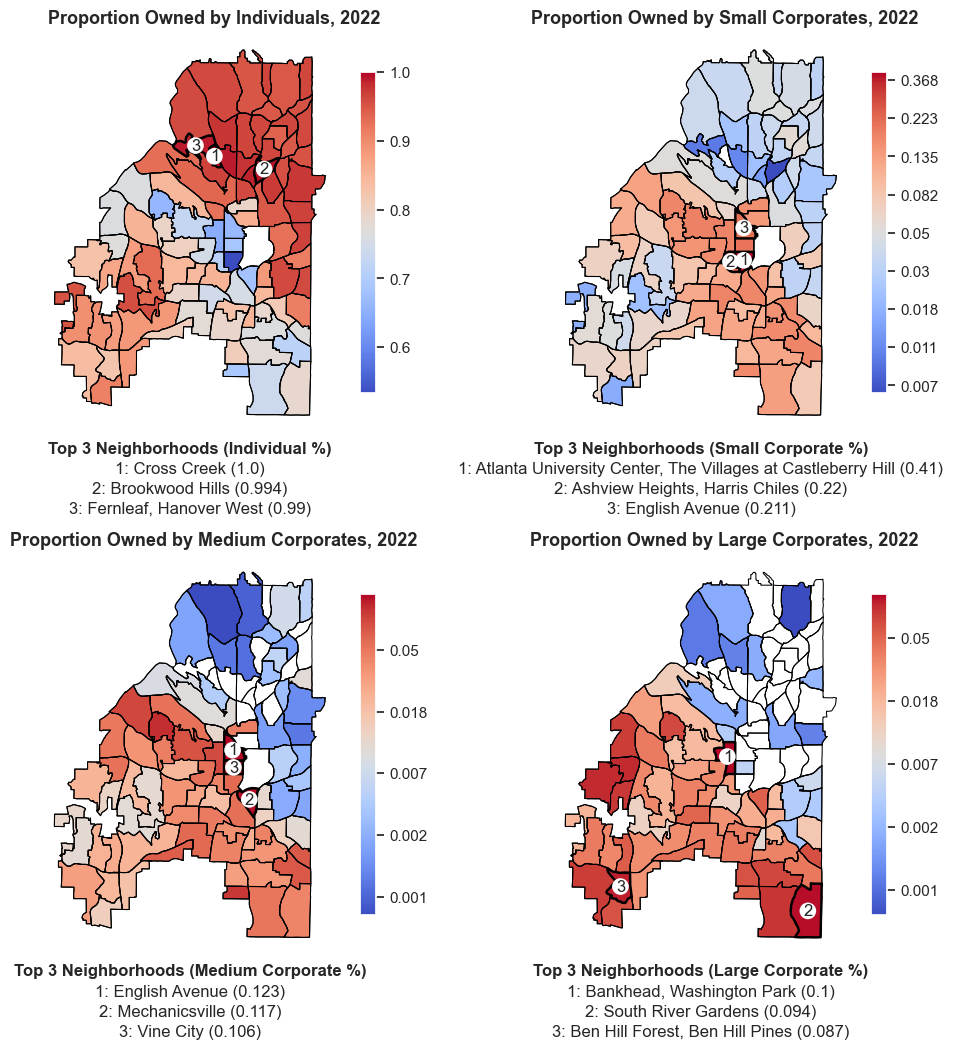

In [24]:
# TODO: make 0 grayed out (could just plot a map underneath)
fig, ax = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': .22, 'hspace': .3})

highlight = [
    [
        "English Avenue",
        'Lakewood, Leila Valley, Norwood Manor, Rebel Valley Forest',
    ],
    [
        'Atlanta University Center, The Villages at Castleberry Hill',
        'Lakewood, Leila Valley, Norwood Manor, Rebel Valley Forest',
    ],
    [
        "English Avenue",
        "Mechanicsville",
    ],
    [
        "South River Gardens",
         'Baker Hills, Bakers Ferry, Boulder Park, Fairburn Road/Wisteria Lane, Ridgecrest Forest, Wildwood (NPU-H), Wilson Mill Meadows, Wisteria Gardens',
    ]
]

log=False
for i, scale in enumerate(scales.values()):
    # neighborhoods we already excluded
    if i in [1, 2, 3]:
        log=True
    else:
        log=False
    utils.map(
        ownership_2022[~ownership_2022["neighborhood"].str.contains("Downtown")],
        color=f"{scale} %",
        title=f"Proportion Owned by {scale}s, 2022",
        nbhd_df=nsa_geo,
        ax=ax.flatten()[i],
        log=log,
        highlight=highlight[i],
    )

## Figure 8. Percent of Sales by Sale Type Map

In [25]:
dfs = [] + [atl_sales_summary]

sale_types = ["corp_bought_ind", "corp_sold_ind", "ind_to_ind", "corp_to_corp"]
for sale in sale_types:
    dfs.append(pd.DataFrame(sales_atl[
        sales_atl[sale] == 1
    ].groupby("neighborhood")["PARID"].count()).rename(columns={"PARID": f"Total {sale}"}).reset_index())
    
atl_sales_summary = reduce(lambda left, right: pd.merge(left, right, on="neighborhood", how="left"), dfs)

atl_sales_summary = atl_sales_summary.fillna(0)
atl_sales_summary['Percent corp_bought_ind'] = atl_sales_summary['Total corp_bought_ind'] / atl_sales_summary['Total Sales']
atl_sales_summary['Percent corp_sold_ind'] = atl_sales_summary['Total corp_sold_ind'] / atl_sales_summary['Total Sales']
atl_sales_summary['Percent ind_to_ind'] = atl_sales_summary['Total ind_to_ind'] / atl_sales_summary['Total Sales']
atl_sales_summary['Percent corp_to_corp'] = atl_sales_summary['Total corp_to_corp'] / atl_sales_summary['Total Sales']
atl_sales_summary.sort_values(by="Percent corp_bought_ind", ascending=False).head(5)

,neighborhood,Total Sales,Invalid Sales,Total Parcels 2022,Sales Per Parcel,Percent Invalid Sales,geometry,Total corp_bought_ind,Total corp_sold_ind,Total ind_to_ind,Total corp_to_corp,Percent corp_bought_ind,Percent corp_sold_ind,Percent ind_to_ind,Percent corp_to_corp
59,Hammond Park,247,128,407,0.60688,0.51822,"POLYGON ((-84.41657 33.67310, -84.41427 33.673...",79.00000,71,66,31.00000,0.31984,0.28745,0.26721,0.12551
81,Perkerson,226,114,480,0.47083,0.50442,"POLYGON ((-84.41669 33.68137, -84.41596 33.681...",60.00000,46,71,49.00000,0.26549,0.20354,0.31416,0.21681
17,"Bankhead Courts, Bankhead/Bolton, Carroll Heig...",585,290,972,0.60185,0.49573,"POLYGON ((-84.51545 33.76516, -84.51535 33.765...",148.00000,128,143,166.00000,0.25299,0.21880,0.24444,0.28376
18,"Bankhead, Washington Park",564,307,893,0.63158,0.54433,"POLYGON ((-84.41751 33.76043, -84.41749 33.762...",142.00000,154,135,133.00000,0.25177,0.27305,0.23936,0.23582
25,"Blair Villa/Poole Creek, Glenrose Heights, Orc...",779,408,1177,0.66185,0.52375,"POLYGON ((-84.39123 33.64812, -84.39122 33.648...",191.00000,209,169,210.00000,0.24519,0.26829,0.21694,0.26958


c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

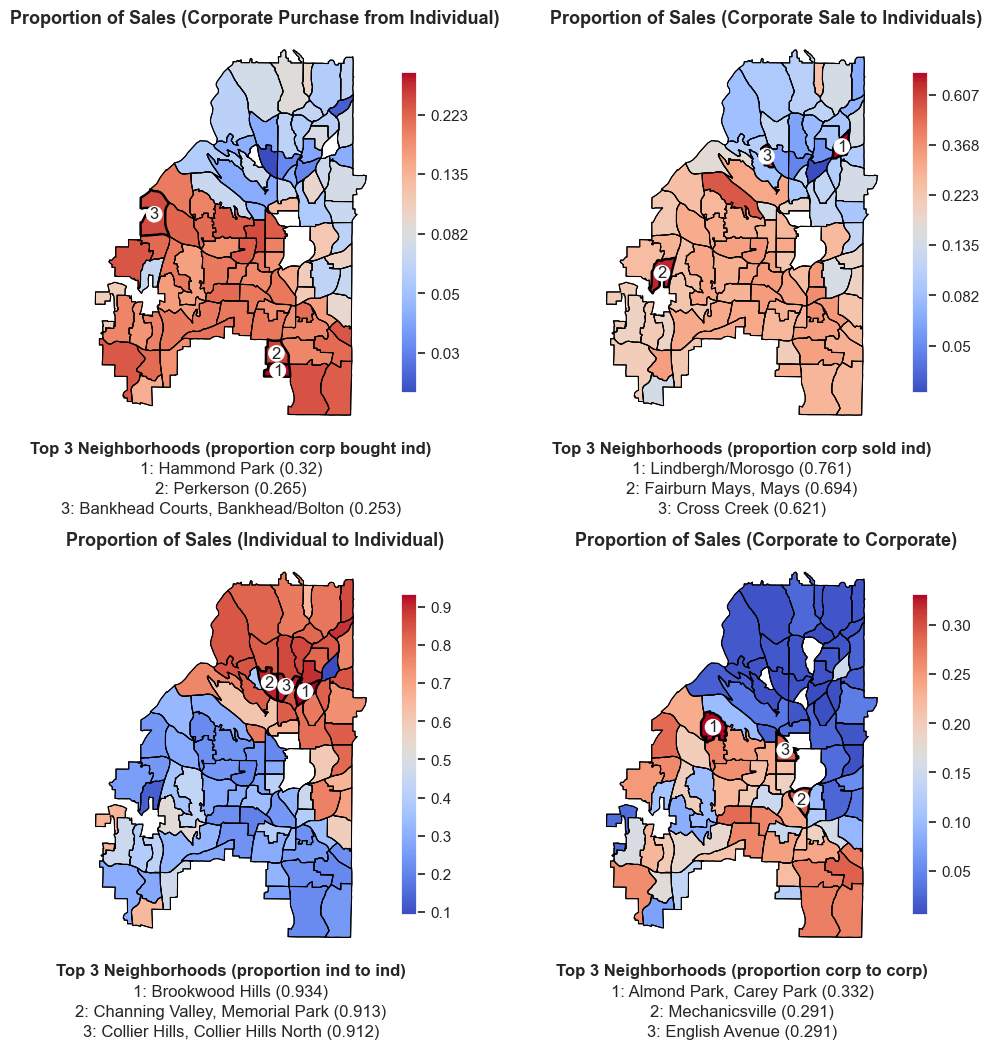

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': .22, 'hspace': .3})

highlight1 = [
    "Hammond Park",
    'Bankhead Courts, Bankhead/Bolton, Carroll Heights, Fairburn Heights, Old Gordon',
]

highlight2 = [
    "Lindbergh/Morosgo",
    "Carver Hills, Rockdale, Scotts Crossing, West Highlands",
    "Fairburn Mays, Mays",
]

highlight3 = [
    'Collier Hills, Collier Hills North, Colonial Homes',
    'Grant Park, Oakland',
]

highlight4 = [
    "Almond Park, Carey Park",
    "Lakewood, Leila Valley, Norwood Manor, Rebel Valley Forest",
]

utils.map(
    atl_sales_summary,
    color="Percent corp_bought_ind",
    title="Proportion of Sales (Corporate Purchase from Individual)",
    nbhd_df=nsa_geo,
    ax=ax[0][0],
    log=True,
    highlight=highlight1
)
utils.map(
    atl_sales_summary,
    color="Percent corp_sold_ind",
    title="Proportion of Sales (Corporate Sale to Individuals)",
    nbhd_df=nsa_geo,
    ax=ax[0][1],
    log=True,
    highlight=highlight2
)
utils.map(
    atl_sales_summary,
    color="Percent ind_to_ind",
    title="Proportion of Sales (Individual to Individual)",
    nbhd_df=nsa_geo,
    ax=ax[1][0],
    highlight=highlight3
)
utils.map(
    atl_sales_summary,
    color="Percent corp_to_corp",
    title="Proportion of Sales (Corporate to Corporate)",
    nbhd_df=nsa_geo,
    ax=ax[1][1],
    highlight=highlight4
)

## Figure 9. Graph of Majority-Black vs Other Neighborhoods by Corporate Purchases and Sales

In [27]:
# Separate neighborhoods into majority Black and other with mb_flag
mb_neighborhoods = nsa_geo[
    nsa_geo["% Not Hispanic Black or African American alone 2021"] >= 50
]["neighborhood"].unique()

sales["mb_flag"] = sales["neighborhood"].apply(lambda x: 1 if x in mb_neighborhoods else 0)
# Agg all sales on mb_flag, calculate total transcations, number where buyer is corp,
# seller is corp, buyer is corp and seller is corp, then calculate percent
total_sales = calculate_counts(sales, "total_sales", group_col=["mb_flag", "Sale Year"])

all_corp_trans = sales[(sales["GRANTEE_corp_flag"] == 1) | (sales["GRANTOR_corp_flag"] == 1)]
corp_trans = calculate_counts(all_corp_trans, "corp_trans", group_col=["mb_flag", "Sale Year"])

mb_summary = total_sales.merge(corp_trans, on=["mb_flag", "Sale Year"], how="left")
mb_summary["% corp"] = mb_summary["corp_trans"] / mb_summary["total_sales"]

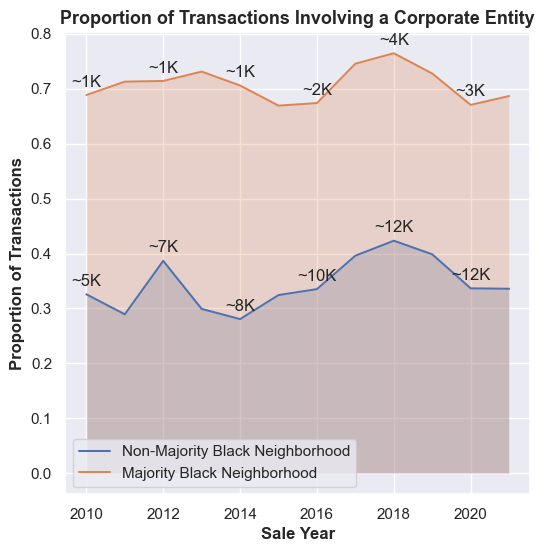

In [28]:
# TODO add in corp to corp / invalid
# TODO for each point, put absolute numbers

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

utils.area_plot(
    mb_summary[mb_summary["mb_flag"] == 0],
    "Sale Year",
    ["% corp"],
    ["Non-Majority Black Neighborhood"],
    "Sale Year",
    title="Proportion of Transactions Involving a Corporate Entity",
    ax=ax,
    legend={"loc": "lower left"},
    ann="total_sales"
)

utils.area_plot(
    mb_summary[mb_summary["mb_flag"] == 1],
    "Sale Year",
    ["% corp"],
    ["Majority Black Neighborhood"],
    "Sale Year",
    "Proportion of Transactions",
    ax=ax,
    legend={"loc": "lower left"},
    ann="total_sales"
)

---
## Equity Loss Figures

## Calculation by Year
Drop outliers where sale_diff is too extreme (multi-parcel sales with properties outside Fulton most likely)

In [29]:
# sale_diff = fmv_adj - price_adj
sales["sale_diff_adj"] = sales["fmv_adj"] - sales["price_adj"]
sales["sale_diff"] = sales["FAIR MARKET VALUE"] - sales["sales_price"]
original_sales = sales.copy(deep=True)

# Calculate the 99th percentile of sale_diff
top_threshold = sales["sale_diff_adj"].quantile(0.99)
bottom_threshold = sales["sale_diff_adj"].quantile(0.01)

# Filter out the rows where sale_diff is greater than the threshold
sales = sales[
    (sales["sale_diff_adj"] < top_threshold)
    & (sales["sale_diff_adj"] > bottom_threshold)
]
dropped_sales = original_sales[(original_sales["sale_diff_adj"] >= top_threshold) | (original_sales["sale_diff_adj"] <= bottom_threshold)]

In [30]:
def agg(df, label, agg_col, group_col='Sale Year'):
    if isinstance(group_col, list):
        return df.groupby(by=group_col)[agg_col].sum().reset_index(name=label)
    else:
        return df.groupby(by=[group_col])[agg_col].sum().reset_index(name=label)
    
# sale loss: aggregate sale_diff where corp_sold_ind = 1
# positive indicates sold for below FMV, company contributed to neighborhood equity
dfs = []
atl_sales = sales[sales["neighborhood"].notna()]

dfs.append(agg(atl_sales[atl_sales["corp_sold_ind"] == 1], "sale_loss_adj", "sale_diff_adj", group_col=["TAXYR", "neighborhood"]))
dfs.append(agg(atl_sales[atl_sales["corp_bought_ind"] == 1], "purchase_loss_adj", "sale_diff_adj", group_col=["TAXYR", "neighborhood"]))

dfs.append(agg(atl_sales[atl_sales["corp_sold_ind"] == 1], "sale_loss", "sale_diff", group_col=["TAXYR", "neighborhood"]))
dfs.append(agg(atl_sales[atl_sales["corp_bought_ind"] == 1], "purchase_loss", "sale_diff", group_col=["TAXYR", "neighborhood"]))

# rental loss: sum of aprtot_adj * .005 * 12 where rental_flag = 1 and own_corp_flag = 1
digest["rental_value_adj"] = digest["Aprtot_adj"] * .005 * 12
digest["rental_value"] = digest["Aprtot"] * .005 * 12

# ignore 2022 rental loss, since sale data ends at 2021
rental_loss_digest = digest[
    (digest["neighborhood"].notna())
    & (digest["rental_flag"] == 1)
    & (digest["own_corp_flag"] == 1)
    & (digest["TAXYR"] < 2022)
]
dfs.append(agg(rental_loss_digest, "rental_loss_adj", "rental_value_adj", group_col=["TAXYR", "neighborhood"]))
dfs.append(agg(rental_loss_digest, "rental_loss", "rental_value", group_col=["TAXYR", "neighborhood"]))

equity_summary = reduce(lambda left, right: pd.merge(left, right, on=["TAXYR", "neighborhood"], how="left"), dfs)

# flip sign so negative is contributing, positive is loss
equity_summary["sale_loss_adj"] = -equity_summary["sale_loss_adj"]
equity_summary["total_loss_adj"] = equity_summary["sale_loss_adj"] + equity_summary["purchase_loss_adj"] + equity_summary["rental_loss_adj"]

equity_summary["sale_loss"] = -equity_summary["sale_loss"]
equity_summary["total_loss"] = equity_summary["sale_loss"] + equity_summary["purchase_loss"] + equity_summary["rental_loss"]

equity_summary = equity_summary.merge(
    nsa_geo,
    on="neighborhood",
    how="left"
)
equity_summary.head(3)

,TAXYR,neighborhood,sale_loss_adj,purchase_loss_adj,sale_loss,purchase_loss,rental_loss_adj,rental_loss,total_loss_adj,total_loss,STATISTICA,geometry,GEOID,Median household income 2021,% Not Hispanic Black or African American alone 2021
0,2011,"Adair Park, Pittsburgh","710,727.65467","284,190.94648","524,859.00000","209,869.66667","1,022,765.99718","777,668.40000","2,017,684.59832","1,512,397.06667",V02,"POLYGON ((-84.40535 33.74403, -84.40447 33.744...",V02,"39,353.00000",75.20000
1,2011,"Adams Park, Laurens Valley, Southwest","191,609.48585","-33,113.91072","141,500.00000","-24,454.00000","427,316.02955","324,913.20000","585,811.60468","441,959.20000",R02,"POLYGON ((-84.47248 33.70263, -84.47117 33.702...",R02,"53,069.00000",93.60000
2,2011,"Adamsville, Oakcliff","-82,940.50183","51,924.13947","-61,250.00000","38,345.00000","269,612.44015","205,002.00000","238,596.07780","182,097.00000",H02,"POLYGON ((-84.50829 33.74873, -84.50820 33.748...",H02,"38,142.00000",96.00000


In [31]:
household_data = pd.read_csv("data/atl_nsa_households.csv", skiprows=1).rename(columns={"Details": "neighborhood"})
household_data.head(2)

,GEOID,neighborhood,Average household size 2021,Median household income 2021,# Age 18 years and over 2021,# Age 21 years and over 2021,# Total households 2021
0,A01,"Margaret Mitchell, Paces, Pleasant Hill",2.40000,NaN,2981,2930,1660
1,A02,"Kingswood, Mt. Paran/Northside, Mt. Paran Park...",2.20000,"154,720.00000",3555,3496,2019


## Total Calculation

In [32]:
dfs = []
dfs.append(agg(equity_summary, "sale_loss_adj", "sale_loss_adj", group_col=["neighborhood"]))
dfs.append(agg(equity_summary, "purchase_loss_adj", "purchase_loss_adj", group_col=["neighborhood"]))
dfs.append(agg(equity_summary, "rental_loss_adj", "rental_loss_adj", group_col=["neighborhood"]))

dfs.append(agg(equity_summary, "sale_loss", "sale_loss", group_col=["neighborhood"]))
dfs.append(agg(equity_summary, "purchase_loss", "purchase_loss", group_col=["neighborhood"]))
dfs.append(agg(equity_summary, "rental_loss", "rental_loss", group_col=["neighborhood"]))

total_equity = reduce(lambda left, right: pd.merge(left, right, on="neighborhood", how="left"), dfs)
total_equity = total_equity.fillna(0)

total_equity["total_loss_adj"] = total_equity["sale_loss_adj"] + total_equity["purchase_loss_adj"] + total_equity["rental_loss_adj"]
total_equity["total_loss"] = total_equity["sale_loss"] + total_equity["purchase_loss"] + total_equity["rental_loss"]

total_equity = total_equity.merge(
    nsa_geo,
    on="neighborhood",
    how="left"
).merge(
    household_data[["neighborhood", "Average household size 2021", "# Total households 2021"]],
    on="neighborhood",
    how="left"
)

In [33]:
total_equity[total_equity["rental_loss_adj"] > 0].sort_values("total_loss_adj", ascending=False).head(4)

,neighborhood,sale_loss_adj,purchase_loss_adj,rental_loss_adj,sale_loss,purchase_loss,rental_loss,total_loss_adj,total_loss,STATISTICA,geometry,GEOID,Median household income 2021,% Not Hispanic Black or African American alone 2021,Average household size 2021,# Total households 2021
65,"Kingswood, Mt. Paran/Northside, Mt. Paran Park...","7,382,099.95390","-3,883,072.97139","40,146,641.88088","6,335,570.00000","-3,223,707.00000","33,592,459.20000","43,645,668.86339","36,704,322.20000",A02,"POLYGON ((-84.40725 33.84953, -84.40723 33.850...",A02,"154,720.00000",8.70000,2.20000,2019
75,Morningside/Lenox Park,"18,938,192.98236","-301,090.64381","19,408,225.56397","15,475,847.00000","-295,877.00000","16,254,778.80000","38,045,327.90251","31,434,748.80000",F04,"POLYGON ((-84.33840 33.80105, -84.33803 33.802...",F04,"127,788.00000",4.90000,2.20000,4748
76,North Buckhead,"13,394,667.44360","-433,572.34113","23,387,035.15143","11,003,022.00000","-386,910.00000","19,617,727.80000","36,348,130.25391","30,233,839.80000",B04,"POLYGON ((-84.38051 33.87572, -84.38064 33.875...",B04,"115,841.00000",11.40000,1.90000,6142
57,"Grant Park, Oakland","17,177,680.61545","3,994,645.47694","14,409,657.16600","13,935,537.00000","3,157,858.00000","12,120,608.40000","35,581,983.25839","29,214,003.40000",W01,"POLYGON ((-84.38070 33.74742, -84.38072 33.746...",W01,"95,867.00000",31.60000,2.10000,3967


In [34]:
total_equity["total_loss_adj"].mean()

13292653.387131805

In [35]:
f"{total_equity["total_loss_adj"].sum():,.0f}"

'1,249,509,418'

In [36]:
digest[
    (digest["neighborhood"].str.contains("Kingswood"))
    & (digest["rental_flag"] == 1)
    & (digest["own_corp_flag"] == 1)
][["PARID", "Situs Adrno", "Situs Adrstr", "owner_addr", "Own1", "Aprtot_adj", "rental_value", "TAXYR"]].sort_values("rental_value", ascending=False).head(10)

,PARID,Situs Adrno,Situs Adrstr,owner_addr,Own1,Aprtot_adj,rental_value,TAXYR
2738202,17 0201 LL0044,4270,HARRIS,0 PO BOX 781 34216,GREEN BIKINI LLC,"12,932,753.17306","681,000.00000",2020
2738201,17 0201 LL0044,4270,HARRIS,0 PO BOX 781 34216,GREEN BIKINI LLC,"9,634,600.00000","578,076.00000",2022
2738203,17 0201 LL0044,4270,HARRIS,0 PO BOX 781 34216,GREEN BIKINI LLC,"9,957,638.24614","561,234.00000",2021
2738398,17 0160 LL0985,830,WEST CONWAY,109453324 PEACHTREE 30326,PACIFIC DEVELOPMENT PARTNERS LLC,"11,507,735.78468","525,000.00000",2011
2738399,17 0160 LL0985,830,WEST CONWAY,109453324 PEACHTREE 30326,PACIFIC DEVELOPMENT PARTNERS LLC,"11,310,812.01737","525,000.00000",2012
1596112,17 0140 LL0030,3800,NORTHSIDE,1235 DUTTON 95401,3800 NORTHSIDE DRIVE LLC,"9,594,211.86307","498,414.00000",2019
1596314,17 0140 LL0030,3800,NORTHSIDE,1235 DUTTON 95401,3800 NORTHSIDE DRIVE LLC,"9,180,596.68276","466,272.00000",2018
2737862,17 016100020171,4370,PARAN,3647 CLOUDLAND 30327,PARAN PLACE LLC,"7,569,533.99886","356,622.00000",2013
1596196,17 0140 LL0030,3800,NORTHSIDE,1235 DUTTON 95401,3800 NORTHSIDE DRIVE LLC,"7,078,852.36569","352,788.00000",2017
2736542,17 016000020131,815,FAIRFIELD,2 CONCOURSE 30328,DRE INVESTMENTS LLC,"5,681,500.00000","340,890.00000",2022


In [37]:
total_equity.sort_values(by="total_loss_adj", ascending=True).head(4)

,neighborhood,sale_loss_adj,purchase_loss_adj,rental_loss_adj,sale_loss,purchase_loss,rental_loss,total_loss_adj,total_loss,STATISTICA,geometry,GEOID,Median household income 2021,% Not Hispanic Black or African American alone 2021,Average household size 2021,# Total households 2021
42,"Castleberry Hill, Downtown",68.36698,0.00000,"31,291.20673",60.00000,0.00000,"29,394.00000","31,359.57370","29,454.00000",M01,"POLYGON ((-84.40038 33.77067, -84.40090 33.770...",M01,"57,283.00000",52.20000,1.40000,7312
29,Brookwood Hills,"841,762.16585","-719,245.73093","425,220.83976","728,900.00000","-603,600.00000","351,474.00000","547,737.27469","476,774.00000",E05,"POLYGON ((-84.38906 33.81767, -84.38916 33.817...",E05,"70,213.00000",12.00000,1.90000,1802
7,"Ardmore, Brookwood","923,887.77585","123,296.95715","328,624.53080","750,371.00000","101,140.00000","272,288.40000","1,375,809.26380","1,123,799.40000",E03,"POLYGON ((-84.39369 33.79628, -84.39367 33.796...",E03,"80,051.00000",22.40000,1.70000,2076
32,"Buckhead Heights, Lenox, Ridgedale Park","445,238.61345",0.00000,"1,096,620.39764","357,381.00000",0.00000,"920,628.00000","1,541,859.01109","1,278,009.00000",B06,"POLYGON ((-84.36774 33.84746, -84.36765 33.847...",B06,"104,745.00000",25.80000,1.50000,2689


## Figure 10. Purchase, Sale, and Rental Equity Loss Map

c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",
c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

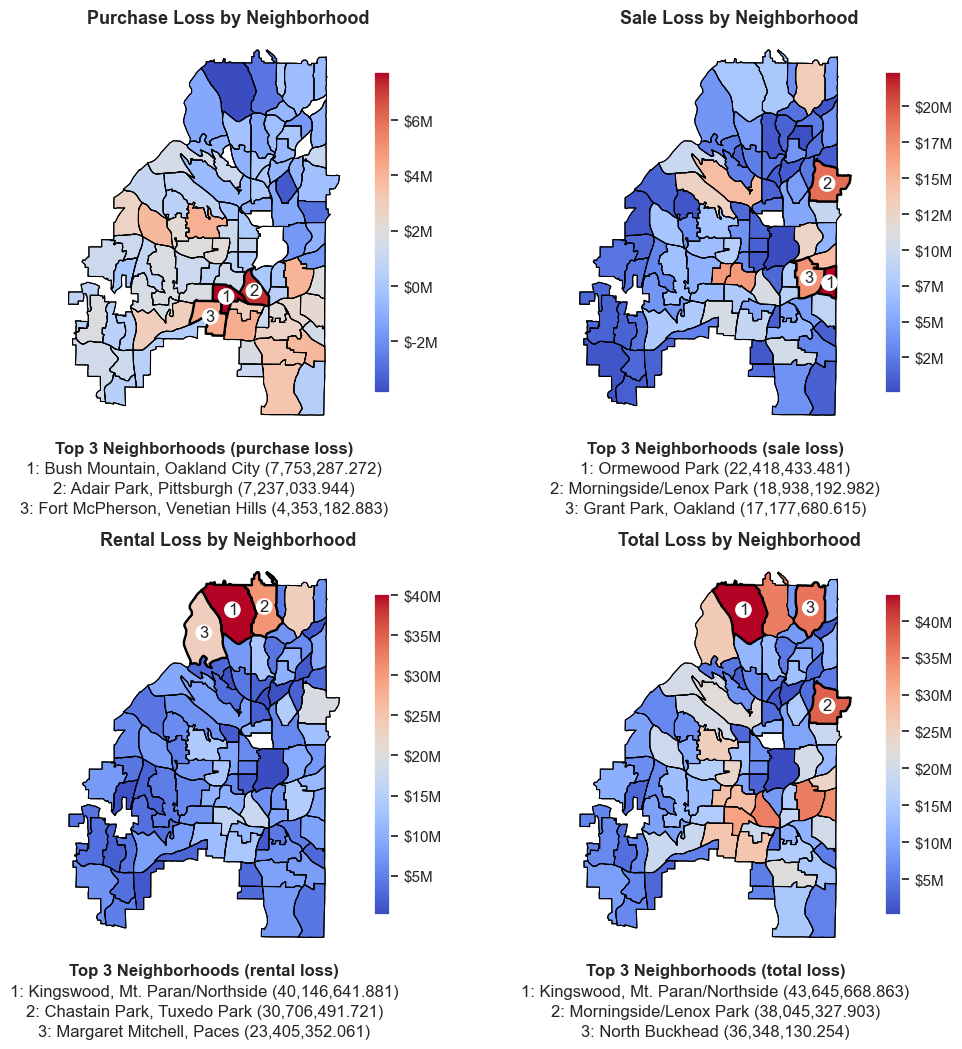

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': .22, 'hspace': .3})

names = {
    "sale_loss_adj": "Sale",
    "purchase_loss_adj": "Purchase",
    "rental_loss_adj": "Rental",
    "total_loss_adj": "Total"
}

j = 0
i = 0

highlight = [
    [
        "Bush Moutain, Oakland City",
        "Adair Park, Pittsburgh",
        "Sylvan Hills"
    ],
    [
        "Morningside/Lenox Park",
        "Ormewood Park",
        "Grant Park, Oakland"
    ],
    [
        "Kingswood, Mt. Paran/Northside, Mt. Paran Parkway, Randall Mill, West Paces Ferry/Northside, Whitewater Creek",
        "Chastain Park, Tuxedo Park",
    ],
    [
        "Kingswood, Mt. Paran/Northside, Mt. Paran Parkway, Randall Mill, West Paces Ferry/Northside, Whitewater Creek",
        "Chastain Park, Tuxedo Park",
        "Ormewood Park",
        "Grant Park, Oakland",
        "Adair Park, Pittsburgh",
    ]
]

h = 0
for color in ["purchase_loss_adj", "sale_loss_adj", "rental_loss_adj", "total_loss_adj"]:
    utils.map(
        total_equity,
        color=color,
        title=f"{names[color]} Loss by Neighborhood",
        nbhd_df=nsa_geo,
        ax=ax[i][j],
        format_func=format_millions,
        highlight=highlight[h],
    )
    h += 1
    j += 1
    if j == 2:
        j = 0
        i += 1


## Figure 11. Equity Burden Map and Boxplot of Majority-Black vs Other Neighborhoods

In [39]:
per_year_nsa = pd.read_csv("data/atl_nsa_by_year.csv").rename(
    columns={
        "tAggregateHHInc_e": "income_generated"
    }
)
per_year_nsa["NSA"] = per_year_nsa["NSA"].astype(str)
per_year_nsa["Year"] = per_year_nsa["Year"].astype(int)
equity_summary["GEOID"] = equity_summary["GEOID"].astype(str)
per_year_nsa["income_generated"] = per_year_nsa.groupby("NSA")["income_generated"].ffill()
per_year_nsa.head(2)

,NSA,Year,income_generated,tAggregateHHInc_m,TotalHH_e,TotalHH_m,aMeanHHIncome_e,aMeanHHIncome_m
0,A01,2012,"411,688,128.00000","59,720,255.00000",1891,135,"217,722.28000","27,470.20000"
1,A02,2012,"502,266,950.00000","94,246,239.00000",1668,154,"301,173.06000","49,209.79000"


In [40]:
equity_summary = equity_summary.merge(
    per_year_nsa,
    left_on=["GEOID", "TAXYR"],
    right_on=["NSA", "Year"],
)

In [41]:
equity_summary.groupby("neighborhood")["total_loss"].sum().sort_values(ascending=False).head(3)

neighborhood
Kingswood, Mt. Paran/Northside, Mt. Paran Parkway, Randall Mill, West Paces Ferry/Northside, Whitewater Creek   33,063,646.20000
Morningside/Lenox Park                                                                                          29,945,275.80000
North Buckhead                                                                                                  27,413,288.80000
Name: total_loss, dtype: float64

In [42]:
equity_summary["equity_burden"] = equity_summary["total_loss"] / equity_summary["income_generated"]
equity_summary.sort_values(by="equity_burden", ascending=False).head(3)

,TAXYR,neighborhood,sale_loss_adj,purchase_loss_adj,sale_loss,purchase_loss,rental_loss_adj,rental_loss,total_loss_adj,total_loss,STATISTICA,geometry,GEOID,Median household income 2021,% Not Hispanic Black or African American alone 2021,NSA,Year,income_generated,tAggregateHHInc_m,TotalHH_e,TotalHH_m,aMeanHHIncome_e,aMeanHHIncome_m,equity_burden
632,2019,"Bush Mountain, Oakland City","394,572.38661","3,701,284.41513","333,998.00000","3,133,066.66667","3,287,599.69737","2,846,483.10000","7,383,456.49911","6,313,547.76667",S01,"POLYGON ((-84.42708 33.73314, -84.42715 33.733...",S01,"31,760.00000",88.80000,S01,2019,"58,932,868.00000","9,089,773.00000",1454,121,"40,523.97000","5,254.32000",0.10713
755,2020,Lakewood Heights,"1,932,387.84887","247,291.56439","1,673,108.00000","214,111.00000","1,328,240.46831","1,165,686.00000","3,507,919.88157","3,052,905.00000",Y04,"POLYGON ((-84.37990 33.71013, -84.38131 33.709...",Y04,"45,657.00000",88.90000,Y04,2020,"35,493,306.00000","11,685,724.00000",690,144,"51,408.15000","13,066.86000",0.08601
554,2018,"Chosewood Park, Englewood Manor","311,937.59107","1,043,564.27609","259,100.00000","866,800.00000","874,113.01955","739,920.00000","2,229,614.88671","1,865,820.00000",Y01,"POLYGON ((-84.36420 33.71207, -84.36484 33.712...",Y01,"37,211.00000",58.90000,Y01,2018,"23,706,966.00000","5,843,273.00000",493,54,"48,042.66000","10,632.98000",0.07870


In [43]:
loss = equity_summary.groupby("neighborhood")["total_loss"].sum()
income = equity_summary.groupby("neighborhood")["income_generated"].sum()

equity_burden = pd.concat([loss, income], axis=1).reset_index()
equity_burden["equity_burden"] = equity_burden["total_loss"] / equity_burden["income_generated"]
equity_burden = equity_burden.merge(
    nsa_geo,
    on="neighborhood",
    how="left"
)
equity_burden["equity_burden"] = equity_burden["equity_burden"].fillna(0)
equity_burden.sort_values(by="equity_burden", ascending=False).head(3)

,neighborhood,total_loss,income_generated,equity_burden,STATISTICA,geometry,GEOID,Median household income 2021,% Not Hispanic Black or African American alone 2021
34,"Bush Mountain, Oakland City","23,573,229.90952","622,021,001.00000",0.03790,S01,"POLYGON ((-84.42708 33.73314, -84.42715 33.733...",S01,"31,760.00000",88.80000
46,"Chosewood Park, Englewood Manor","8,798,048.60000","245,249,444.00000",0.03587,Y01,"POLYGON ((-84.36420 33.71207, -84.36484 33.712...",Y01,"37,211.00000",58.90000
93,Westview,"21,709,318.42000","664,671,647.00000",0.03266,T03,"POLYGON ((-84.43288 33.73904, -84.43285 33.739...",T03,"47,106.00000",82.20000


In [44]:
total_equity.sort_values(by="total_loss", ascending=False).head(3)

,neighborhood,sale_loss_adj,purchase_loss_adj,rental_loss_adj,sale_loss,purchase_loss,rental_loss,total_loss_adj,total_loss,STATISTICA,geometry,GEOID,Median household income 2021,% Not Hispanic Black or African American alone 2021,Average household size 2021,# Total households 2021
65,"Kingswood, Mt. Paran/Northside, Mt. Paran Park...","7,382,099.95390","-3,883,072.97139","40,146,641.88088","6,335,570.00000","-3,223,707.00000","33,592,459.20000","43,645,668.86339","36,704,322.20000",A02,"POLYGON ((-84.40725 33.84953, -84.40723 33.850...",A02,"154,720.00000",8.70000,2.20000,2019
75,Morningside/Lenox Park,"18,938,192.98236","-301,090.64381","19,408,225.56397","15,475,847.00000","-295,877.00000","16,254,778.80000","38,045,327.90251","31,434,748.80000",F04,"POLYGON ((-84.33840 33.80105, -84.33803 33.802...",F04,"127,788.00000",4.90000,2.20000,4748
0,"Adair Park, Pittsburgh","10,843,104.76218","7,237,033.94373","17,298,046.07168","9,188,729.89286","6,294,731.33333","14,843,802.18000","35,378,184.77759","30,327,263.40619",V02,"POLYGON ((-84.40535 33.74403, -84.40447 33.744...",V02,"39,353.00000",75.20000,2.20000,1930


c:\Users\Nick\Documents\code\equity-extraction\utils.py:262: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  + f" ({round(float(df[df['neighborhood'] == name][color]), 3):,})",


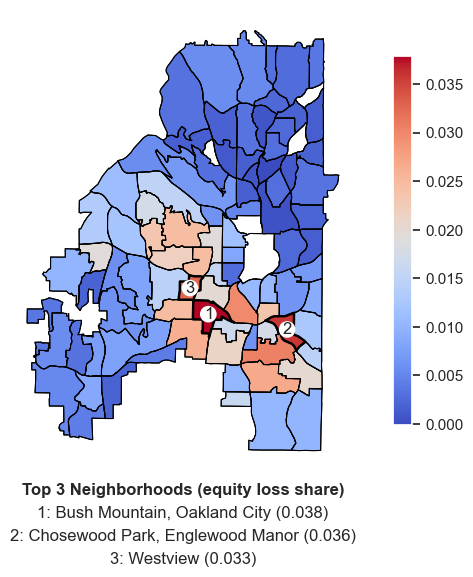

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

highlight = [
    'Chosewood Park, Englewood Manor',
    'Grove Park',
    'Browns Mill Park, Polar Rock, Swallow Circle/Baywood',
    'Bush Mountain, Oakland City',
]
utils.map(
    equity_burden,
    color="equity_burden",
    title="",
    nbhd_df=nsa_geo,
    ax=ax,
    highlight=highlight,
)

In [46]:
equity_burden.sort_values("equity_burden", ascending=False).head(10)

,neighborhood,total_loss,income_generated,equity_burden,STATISTICA,geometry,GEOID,Median household income 2021,% Not Hispanic Black or African American alone 2021
34,"Bush Mountain, Oakland City","23,573,229.90952","622,021,001.00000",0.03790,S01,"POLYGON ((-84.42708 33.73314, -84.42715 33.733...",S01,"31,760.00000",88.80000
46,"Chosewood Park, Englewood Manor","8,798,048.60000","245,249,444.00000",0.03587,Y01,"POLYGON ((-84.36420 33.71207, -84.36484 33.712...",Y01,"37,211.00000",58.90000
93,Westview,"21,709,318.42000","664,671,647.00000",0.03266,T03,"POLYGON ((-84.43288 33.73904, -84.43285 33.739...",T03,"47,106.00000",82.20000
67,Lakewood Heights,"11,367,764.40000","372,650,605.00000",0.03051,Y04,"POLYGON ((-84.37990 33.71013, -84.38131 33.709...",Y04,"45,657.00000",88.90000
0,"Adair Park, Pittsburgh","25,312,483.33952","848,029,600.00000",0.02985,V02,"POLYGON ((-84.40535 33.74403, -84.40447 33.744...",V02,"39,353.00000",75.20000
30,"Browns Mill Park, Polar Rock, Swallow Circle/B...","16,541,553.96190","618,144,437.00000",0.02676,Z04,"POLYGON ((-84.39870 33.68587, -84.39873 33.685...",Z04,"31,158.00000",87.20000
55,"Fort McPherson, Venetian Hills","21,014,782.38095","799,641,130.00000",0.02628,S02,"POLYGON ((-84.42606 33.71464, -84.42723 33.714...",S02,"37,062.00000",88.70000
62,"Hunter Hills, Mozley Park","18,447,402.71333","749,463,775.00000",0.02461,K01,"POLYGON ((-84.43355 33.75590, -84.43420 33.755...",K01,"33,621.00000",85.30000
40,Cascade Avenue/Road,"11,561,196.00000","470,412,435.00000",0.02458,S03,"POLYGON ((-84.43991 33.72251, -84.43876 33.722...",S03,"32,581.00000",92.00000
59,Grove Park,"17,739,278.04000","722,304,441.00000",0.02456,J02,"POLYGON ((-84.45646 33.78600, -84.45656 33.785...",J02,"26,358.00000",87.50000


In [47]:
equity_burden["income_generated"].sum() - per_year_nsa[per_year_nsa["Year"] != 2012]["tAggregateHHInc_m"].sum()

143590479841.0

In [48]:
equity_summary.sort_values("equity_burden", ascending=False).head(1)

,TAXYR,neighborhood,sale_loss_adj,purchase_loss_adj,sale_loss,purchase_loss,rental_loss_adj,rental_loss,total_loss_adj,total_loss,STATISTICA,geometry,GEOID,Median household income 2021,% Not Hispanic Black or African American alone 2021,NSA,Year,income_generated,tAggregateHHInc_m,TotalHH_e,TotalHH_m,aMeanHHIncome_e,aMeanHHIncome_m,equity_burden
632,2019,"Bush Mountain, Oakland City","394,572.38661","3,701,284.41513","333,998.00000","3,133,066.66667","3,287,599.69737","2,846,483.10000","7,383,456.49911","6,313,547.76667",S01,"POLYGON ((-84.42708 33.73314, -84.42715 33.733...",S01,"31,760.00000",88.80000,S01,2019,"58,932,868.00000","9,089,773.00000",1454,121,"40,523.97000","5,254.32000",0.10713


In [49]:
total_equity.agg({"sale_loss": sum, "purchase_loss": sum, "rental_loss": sum, "total_loss": sum})

C:\Users\Nick\AppData\Local\Temp\ipykernel_30824\672493611.py:1: FutureWarning: The provided callable <built-in function sum> is currently using Series.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_equity.agg({"sale_loss": sum, "purchase_loss": sum, "rental_loss": sum, "total_loss": sum})


sale_loss         393,693,325.57143
purchase_loss      66,534,302.00000
rental_loss       595,549,428.12000
total_loss      1,055,777,055.69143
dtype: float64

In [50]:
total_equity["mb_flag"] = total_equity["neighborhood"].apply(lambda x: 1 if x in mb_neighborhoods else 0)

In [51]:
total_equity.groupby("mb_flag")["total_loss_adj"].sum()

mb_flag
0   568,017,383.21933
1   681,492,035.17106
Name: total_loss_adj, dtype: float64

Average equity burden for mb and non-mb neighborhoods (sum mb generation, mb generation)

In [52]:
equity_burden["mb_flag"] = equity_burden["neighborhood"].apply(lambda x: 1 if x in mb_neighborhoods else 0)

In [53]:
equity_burden.groupby("mb_flag")["income_generated"].sum() * (digest["TAXYR"].nunique() - 1)

mb_flag
0   1,733,382,506,796.00000
1     453,857,804,688.00000
Name: income_generated, dtype: float64

In [54]:
equity_burden.groupby("mb_flag")["total_loss"].sum() / equity_burden.groupby("mb_flag")["income_generated"].sum() * 100

mb_flag
0   0.28452
1   1.33930
dtype: float64

In [55]:
equity_summary.sort_values("equity_burden", ascending=False).head(3)

,TAXYR,neighborhood,sale_loss_adj,purchase_loss_adj,sale_loss,purchase_loss,rental_loss_adj,rental_loss,total_loss_adj,total_loss,STATISTICA,geometry,GEOID,Median household income 2021,% Not Hispanic Black or African American alone 2021,NSA,Year,income_generated,tAggregateHHInc_m,TotalHH_e,TotalHH_m,aMeanHHIncome_e,aMeanHHIncome_m,equity_burden
632,2019,"Bush Mountain, Oakland City","394,572.38661","3,701,284.41513","333,998.00000","3,133,066.66667","3,287,599.69737","2,846,483.10000","7,383,456.49911","6,313,547.76667",S01,"POLYGON ((-84.42708 33.73314, -84.42715 33.733...",S01,"31,760.00000",88.80000,S01,2019,"58,932,868.00000","9,089,773.00000",1454,121,"40,523.97000","5,254.32000",0.10713
755,2020,Lakewood Heights,"1,932,387.84887","247,291.56439","1,673,108.00000","214,111.00000","1,328,240.46831","1,165,686.00000","3,507,919.88157","3,052,905.00000",Y04,"POLYGON ((-84.37990 33.71013, -84.38131 33.709...",Y04,"45,657.00000",88.90000,Y04,2020,"35,493,306.00000","11,685,724.00000",690,144,"51,408.15000","13,066.86000",0.08601
554,2018,"Chosewood Park, Englewood Manor","311,937.59107","1,043,564.27609","259,100.00000","866,800.00000","874,113.01955","739,920.00000","2,229,614.88671","1,865,820.00000",Y01,"POLYGON ((-84.36420 33.71207, -84.36484 33.712...",Y01,"37,211.00000",58.90000,Y01,2018,"23,706,966.00000","5,843,273.00000",493,54,"48,042.66000","10,632.98000",0.07870


In [56]:
equity_burden[equity_burden["neighborhood"].str.contains("Bush")]

,neighborhood,total_loss,income_generated,equity_burden,STATISTICA,geometry,GEOID,Median household income 2021,% Not Hispanic Black or African American alone 2021,mb_flag
34,"Bush Mountain, Oakland City","23,573,229.90952","622,021,001.00000",0.03790,S01,"POLYGON ((-84.42708 33.73314, -84.42715 33.733...",S01,"31,760.00000",88.80000,1


Change median to avg household income... neeed to change for BUsh mountain in section too

In [57]:
# sum equity loss for each year by nbhd type
# sum household size * total households for each year by nbhd type
total_loss = equity_burden.groupby("mb_flag")["total_loss"].sum()
total_generation = equity_burden.groupby("mb_flag")["income_generated"].sum() * (digest["TAXYR"].nunique() - 1)

overall_pct = pd.concat([total_loss, total_generation], axis=1)
overall_pct["pct"] = overall_pct["total_loss"] / overall_pct["income_generated"] * 100
overall_pct

,total_loss,income_generated,pct
mb_flag,,,
0,"410,982,779.30286","1,733,382,506,796.00000",0.02371
1,"506,543,722.29429","453,857,804,688.00000",0.11161


---
## Statistical Tests: Corporate Power

**Motivating question:** is the price paid (and sale_diff) different by sale type?

sale_diff = fmv_adj - price_adj

sale_type = corp to ind, ind to corp, etc.

**Model type**: Mixed Linear Model

**Model characteristics**
- Groups: neighborhoods and sale year (need to drop first year to avoid dummy trap)
- Treatment: type of sale (also need to avoid dummy trap, reference param in statsmodels library should do this)
- Dependent vars: sales price (log), sales_diff
- Covariates: 
    - Fixed effect: whether sale is valid, num beds, num baths, sqft living area, year built, heat
    - Random effect: sale year as level 1, neighborhoods nested within as level 2 - ADD TO MODEL

**Notes**
- Allow slopes and intercepts to vary?
- add in taxyr dummy, omitting first year (0): need to drop first year
- num bath, num bed, amenities, lot size, AC or not
- cluster standard errors at nbhd level

**Steps (do separately for each DV)**
- **Run model**
- **Residuals vs fitted plot (entire model):** verify there are no patterns, should be randomly distributed around zero
- **Residuals for each predictor variable:** verify no patterns
- **Distribution of residuals (QQ plot):** verify normal
- **Distribution of random effects (QQ plot):** verify normal
- **Variance inflation factors of IVs:** verify none are above 5-10
- **Correlation matrix of IVs:** verify all below 0.8
- **Degrees of Freedom:**
- **Confidence Intervals:** verify CIs don't include 0

In [58]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

Prepare data: cast all int/float, take log of sales price, create dummy column

In [59]:
# Use heat, 4 = Central Air, 3 is forced air, 2 non central, 1 is none
# from understanding the PRC
sales_stat_vars = {
    "Sale Year": "int",
    "neighborhood": "string",
    "corp_sold_ind": "int",
    "corp_bought_ind": "int",
    "ind_to_ind": "int",
    "corp_to_corp": "int",
    "Saleval": "string",
    "sales_price": "float",
    "FAIR MARKET VALUE": "float",
    "price_adj": "float",
    "sale_diff": "float",
    "sqft_living": "float",
    "yr_built": "int",
    "beds": "int",
    "baths": "int",
    "acres": "float",
    "heat": "int",
    "D Effyr": "int",
    "Extwall": "int",
    "Style": "string",
    "Rmtot": "int",
    "D Grade": "string",
    "Bsmt": "int"
}
sale_type_names = [
    "ind_to_ind",
    "corp_to_corp",
    "corp_bought_ind",
    "corp_sold_ind",
]
sales_atl = sales[sales["neighborhood"].notna()]
sales_atl = sales_atl.merge(digest[
    ["TAXYR", "PARID", "yr_built", "sqft_living", "beds", "baths", "acres", "heat", "D Effyr", "Extwall", "Style", "Rmtot", "D Grade", "Bsmt"]
], on=["PARID", "TAXYR"], how="left")
sales_for_stat = sales_atl[sales_stat_vars.keys()].copy()
init_len = len(sales_for_stat)
sales_for_stat = sales_for_stat.dropna()
print(f"Dropped {init_len - len(sales_for_stat)} records due to missing values from digest merge")
sales_for_stat["sale_type"] = pd.from_dummies(sales_for_stat[sale_type_names])
sales_for_stat["valid_sale"] = sales_for_stat.apply(
    lambda x: x["Saleval"] == "0",
    axis=1
).astype(int)

sales_for_stat["sale_type"] = pd.from_dummies(sales_for_stat[sale_type_names])

for col, dtype in sales_stat_vars.items():
    sales_for_stat[col] = sales_for_stat[col].astype(dtype)

# natural log of sales price (adj for inflation)
sales_for_stat["price_adj_log"] = np.log(sales_for_stat["price_adj"])
sales_for_stat.rename(columns={"Sale Year": "sale_year"}, inplace=True)

# save data for validation
sales_for_stat.to_csv("output/sales_for_stat.csv", index=False)

Dropped 746 records due to missing values from digest merge


Data Check for Dist of sale_diff: fmv_adj - price_adj

In [60]:
sales_for_stat["sale_diff"].describe()

count     53,527.00000
mean     -25,377.77549
std       69,922.98812
min     -430,400.00000
25%      -46,000.00000
50%       -4,500.00000
75%            0.00000
max      299,147.00000
Name: sale_diff, dtype: float64

Helper Functions

In [61]:
def run_model(df, formula, groups, re_formula="1"):
    formula = formula
    model = smf.mixedlm(formula, df, groups=df[groups], re_formula=re_formula)
    return model.fit()

def verbose_output(result):
    print(result.summary())
    print(result.random_effects)
    print(result.cov_re)
    print(result.cov_params())
    
    # for name, coef in zip(mixed_lm_result.model.exog_names, mixed_lm_result.params):
    #     percent_change = (np.exp(coef) - 1) * 100
    #     print(f"{name}: {percent_change:.2f}%")
    
def model_residuals(result):
    fitted_vals = result.fittedvalues
    residuals = result.resid
    plt.scatter(fitted_vals, residuals)
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()
    
def predictor_residuals(df, result, predictor):
    residuals = result.resid
    plt.scatter(df[predictor], residuals)
    plt.xlabel(f'{predictor}')
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()
    
def dist_residuals(result):
    residuals = result.resid
    fig = sm.qqplot(residuals, stats.t, fit=True, line="45")
    plt.show()
    
def dist_random_effects(result):
    random_effects = result.random_effects
    # Flatten the array for plotting
    #re_flat = np.concatenate([re.flatten() for re in random_effects.values()])
    print(random_effects)
    fig = sm.qqplot(random_effects, stats.t, fit=True, line="45")
    plt.show()
    
def vif(df, predictors):
    pred = df[predictors]
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(pred.values, i) for i in range(pred.shape[1])]
    vif["features"] = pred.columns
    print(vif)
    
def corr_matrix(df, predictors):
    pred = df[predictors]
    corr_matrix = pred.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.show()

def run_diagnostics(df, result, predictors):
    model_residuals(result)
    
    for predictor in predictors:
        predictor_residuals(df, result, predictor)
        
    dist_residuals(result)
    #dist_random_effects(result)
    #dist_random_effects(result, predictors)
    vif(df, predictors)
    corr_matrix(df, predictors)

### Model - Sales Price

In [62]:
formula = 'price_adj_log ~ C(sale_type, Treatment(reference="ind_to_ind")) + C(valid_sale) + beds + baths + sqft_living + yr_built + C(heat) + C(sale_year)'
result = run_model(df=sales_for_stat, formula=formula, groups="neighborhood")
verbose_output(result)

                                    Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  price_adj_log
No. Observations:                  53527                    Method:                              REML         
No. Groups:                        95                       Scale:                               0.3803       
Min. group size:                   1                        Log-Likelihood:                      -50479.9905  
Max. group size:                   1889                     Converged:                           Yes          
Mean group size:                   563.4                                                                      
--------------------------------------------------------------------------------------------------------------
                                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------

In [63]:
sales_for_stat["price_adj_log"].describe()

count   53,527.00000
mean        12.28923
std          1.40142
min          6.76415
25%         11.38211
50%         12.53098
75%         13.34822
max         16.38880
Name: price_adj_log, dtype: float64

In [64]:
for name, coef in zip(result.model.exog_names, result.params):
    percent_change = (np.exp(coef) - 1) * 100
    print(f"{name}: {percent_change:.2f}%")

Intercept: 154060.22%
C(sale_type, Treatment(reference="ind_to_ind"))[T.corp_bought_ind]: -34.02%
C(sale_type, Treatment(reference="ind_to_ind"))[T.corp_sold_ind]: 11.12%
C(sale_type, Treatment(reference="ind_to_ind"))[T.corp_to_corp]: -26.99%
C(valid_sale)[T.1]: 33.15%
C(heat)[T.2]: -16.39%
C(heat)[T.3]: -5.23%
C(heat)[T.4]: 18.55%
C(sale_year)[T.2011]: -4.70%
C(sale_year)[T.2012]: -10.35%
C(sale_year)[T.2013]: 4.48%
C(sale_year)[T.2014]: 17.77%
C(sale_year)[T.2015]: 47.45%
C(sale_year)[T.2016]: 51.26%
C(sale_year)[T.2017]: 89.78%
C(sale_year)[T.2018]: 142.73%
C(sale_year)[T.2019]: 154.42%
C(sale_year)[T.2020]: 175.34%
C(sale_year)[T.2021]: 212.89%
beds: 0.24%
baths: 11.72%
sqft_living: 0.02%
yr_built: 0.18%


Diagnostics

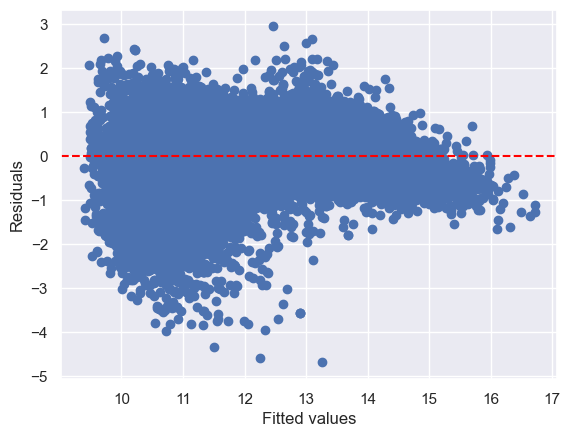

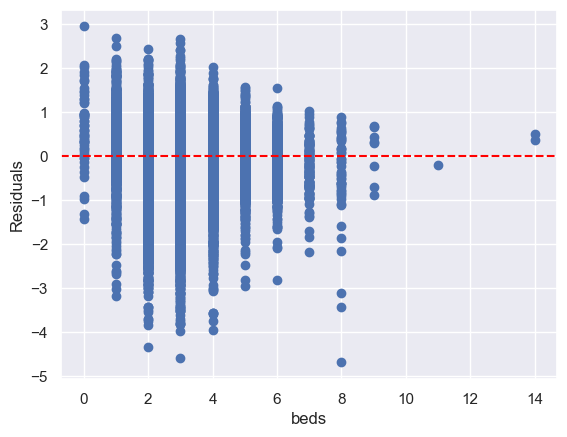

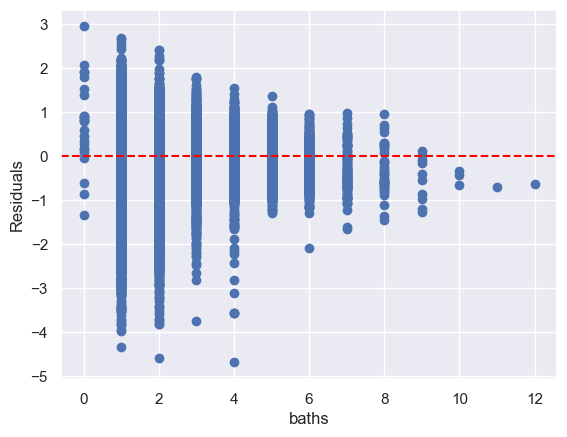

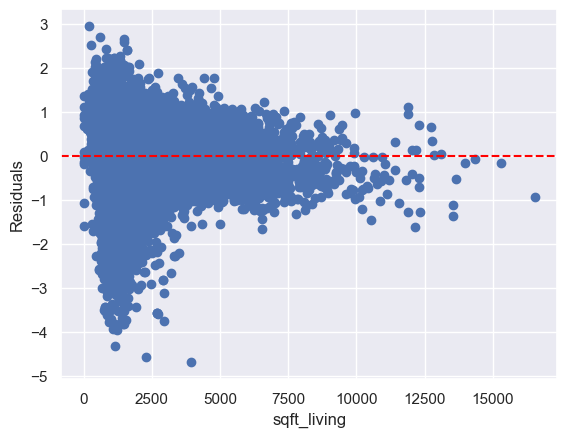

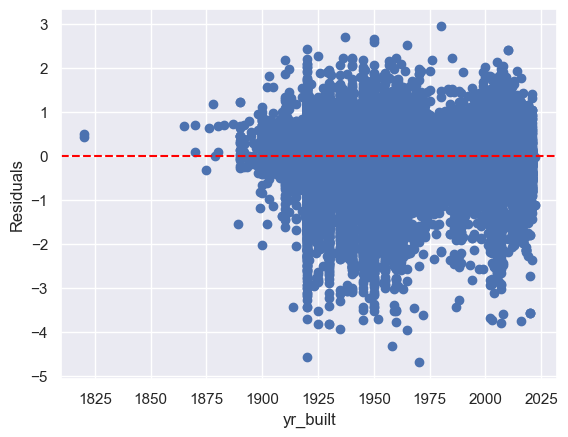

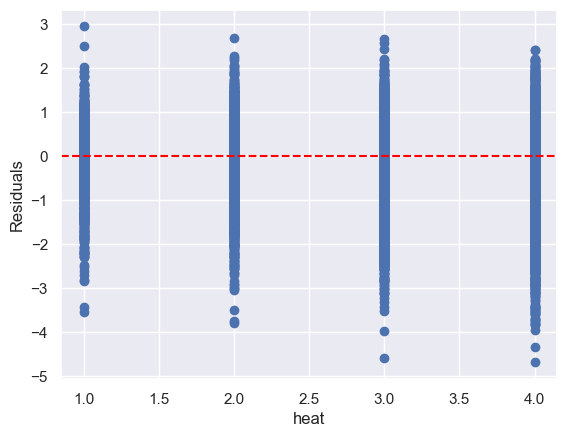

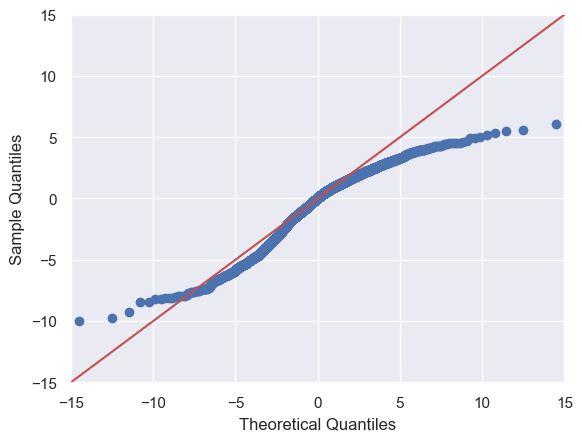

   VIF Factor     features
0    24.99730         beds
1    15.43490        baths
2     9.97257  sqft_living
3    39.12068     yr_built
4    34.42175         heat


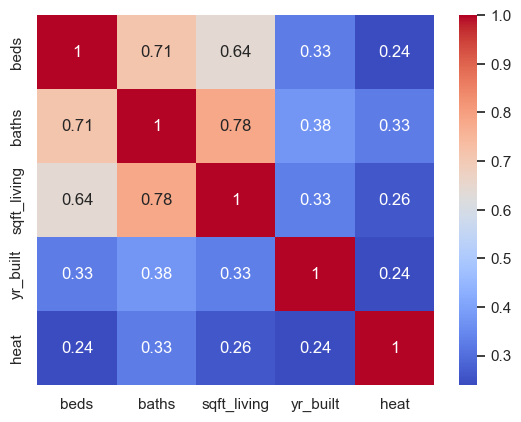

In [65]:
run_diagnostics(sales_for_stat, result, ["beds", "baths", "sqft_living", "yr_built", "heat"])

### Model - Sale Diff

In [66]:
formula = 'sale_diff ~ sale_type + valid_sale + num_beds + num_baths + sqft_living + year_built + heat'
result = run_model(df=sales_for_stat, formula=formula, groups="neighborhood", re_formula="~sale_year")
verbose_output(result)

PatsyError: Error evaluating factor: NameError: name 'num_baths' is not defined
    sale_diff ~ sale_type + valid_sale + num_beds + num_baths + sqft_living + year_built + heat
                                                    ^^^^^^^^^

Diagnostics

In [ ]:
run_diagnostics(sales_for_stat, result, ["num_beds", "num_baths", "sqft_living", "year_built", "heat"])